In [1]:
#!pip install scikit-optimize
#!pip install lightgbm
#!pip install tensorflow

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn import tree
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import lightgbm as lgb
from lightgbm import LGBMClassifier
import logging
from sklearn.svm import SVC
import time

In [3]:
file_path = 'SBA_tisztitott.csv'
df_sba=pd.read_csv(file_path, parse_dates=['ApprovalDate','DisbursementDate'])
df_sba.head()

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,PaidBack
0,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,1997-02-28,1997,84,...,False,True,NaN,1999-02-28,60000.0,0.0,0.0,60000.0,48000.0,True
1,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,72,1997-02-28,1997,60,...,False,True,NaN,1997-05-31,40000.0,0.0,0.0,40000.0,32000.0,True
2,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,62,1997-02-28,1997,180,...,False,False,NaN,1997-12-31,287000.0,0.0,0.0,287000.0,215250.0,True
3,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,60,...,False,True,NaN,1997-06-30,35000.0,0.0,0.0,35000.0,28000.0,True
4,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,240,...,False,False,NaN,1997-05-14,229000.0,0.0,0.0,229000.0,229000.0,True


In [4]:
def describe_data(df):
    print(len(df_sba))
    column=[]
    d_type=[]
    uniques=[]
    n_uniques=[]
    nan=[]
    d_min=[]
    d_max=[]

    for i in df.columns:
        column.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
        nan.append(df[i].isna().sum()/len(df)*100)
        if df[i].dtype != 'object':
            d_min.append(df[i].min())
        else:
            d_min.append(None)
        if df[i].dtype != 'object':
            d_max.append(df[i].max())
        else:
            d_max.append(None)

    return pd.DataFrame({'Column': column, 'type': d_type, 'unique sample': uniques, 'uniques': n_uniques, 'NaN%': nan, 'Min': d_min, 'Max': d_max})



In [5]:
describe_data(df_sba)

868076


,Column,type,unique sample,uniques,NaN%,Min,Max
0,Name,object,"[ABC HOBBYCRAFT, LANDMARK BAR & GRILLE (THE), ...",755201,0.000000,None,None
1,City,object,"[EVANSVILLE, NEW PARIS, BLOOMINGTON, BROKEN AR...",32035,0.000000,None,None
2,State,object,"[IN, OK, FL, CT, NJ]",51,0.000000,None,None
3,Zip,int64,"[47711, 46526, 47401, 74012, 32801]",33392,0.000000,0,99999
4,Bank,object,"[FIFTH THIRD BANK, 1ST SOURCE BANK, GRANT COUN...",5784,0.000000,None,None
5,BankState,object,"[OH, IN, OK, FL, DE]",56,0.000000,None,None
6,NAICS,int64,"[45, 72, 62, 0, 33]",25,0.000000,0,92
7,ApprovalDate,datetime64[ns],"[1997-02-28T00:00:00.000000000, 1980-06-02T00:...",9781,0.000000,1969-04-28 00:00:00,2014-06-25 00:00:00
8,ApprovalFY,int64,"[1997, 1980, 2006, 1998, 1999]",46,0.000000,1969,2014
9,Term,int64,"[84, 60, 180, 240, 120]",410,0.000000,0,569


In [6]:
df_sba = df_sba.drop(columns=['ChgOffDate'])

In [7]:
df_sba['DisbursementGross'] = df_sba['DisbursementGross'].astype('int64')
df_sba['BalanceGross'] = df_sba['BalanceGross'].astype('int64')
df_sba['ChgOffPrinGr'] = df_sba['ChgOffPrinGr'].astype('int64')
df_sba['GrAppv'] = df_sba['GrAppv'].astype('int64')
df_sba['SBA_Appv'] = df_sba['SBA_Appv'].astype('int64')
df_sba['PaidBack'] = df_sba['PaidBack'].astype(int)

In [8]:
#nem relevánsak
df_sba = df_sba.drop(columns=['City','Zip','Name','Bank','BankState','ApprovalDate','ApprovalFY','DisbursementDate'],axis=1)

In [9]:
#nem ismerhetjük hitelkérelem elbírálása során
df_sba = df_sba.drop(columns=['BalanceGross','ChgOffPrinGr','GrAppv'],axis=1)

In [10]:
len(df_sba[df_sba.NAICS==0])

197201

In [11]:
df_sba=df_sba[df_sba.NAICS!=0]

In [12]:
len(df_sba[df_sba.UrbanRural==0])

140245

In [13]:
df_sba=df_sba[df_sba.UrbanRural!=0]

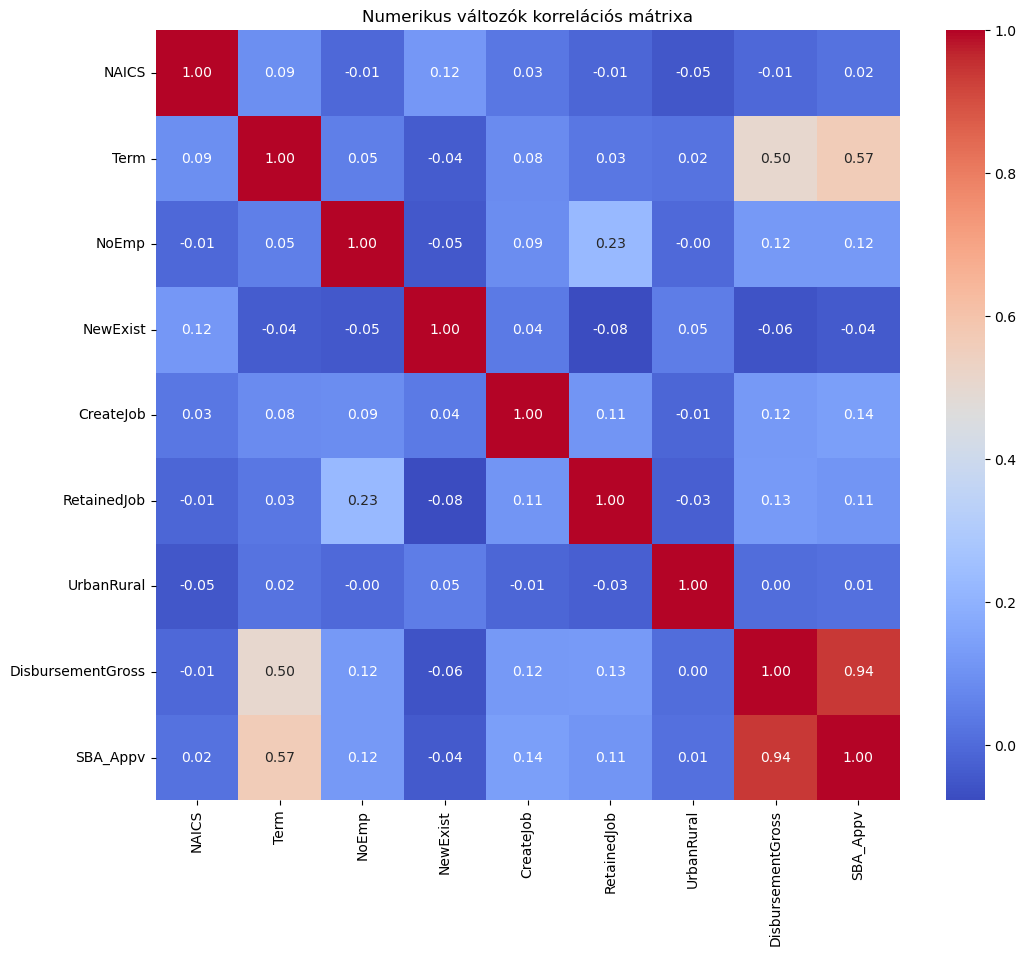

In [14]:
numeric_columns = df_sba.select_dtypes(include=['int64']).columns
correlation_matrix = df_sba[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numerikus változók korrelációs mátrixa')
plt.show()

In [15]:
correlation_data = []
continuous_variables = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'SBA_Appv']
binary_variables=['UrbanRural','NewExist','RevLineCr','LowDoc','PaidBack']
for binary_variable in binary_variables:
    print(f"{binary_variable}")
    for continuous_variable in continuous_variables:
        correlation_coefficient, p_value = pointbiserialr(df_sba[binary_variable], df_sba[continuous_variable])
        print(f"\t{continuous_variable}: {correlation_coefficient:.2f}, p érték: {p_value:.2f}")
        correlation_data.append({'Binary Variable': binary_variable, 'Continuous Variable': continuous_variable, 'Correlation Coefficient': correlation_coefficient})

UrbanRural
	Term: 0.02, p érték: 0.00
	NoEmp: -0.00, p érték: 0.09
	CreateJob: -0.01, p érték: 0.00
	RetainedJob: -0.03, p érték: 0.00
	DisbursementGross: 0.00, p érték: 0.00
	SBA_Appv: 0.01, p érték: 0.00
NewExist
	Term: -0.04, p érték: 0.00
	NoEmp: -0.05, p érték: 0.00
	CreateJob: 0.04, p érték: 0.00
	RetainedJob: -0.08, p érték: 0.00
	DisbursementGross: -0.06, p érték: 0.00
	SBA_Appv: -0.04, p érték: 0.00
RevLineCr
	Term: -0.35, p érték: 0.00
	NoEmp: -0.04, p érték: 0.00
	CreateJob: -0.05, p érték: 0.00
	RetainedJob: 0.00, p érték: 0.35
	DisbursementGross: -0.21, p érték: 0.00
	SBA_Appv: -0.31, p érték: 0.00
LowDoc
	Term: -0.03, p érték: 0.00
	NoEmp: -0.01, p érték: 0.00
	CreateJob: -0.05, p érték: 0.00
	RetainedJob: -0.07, p érték: 0.00
	DisbursementGross: -0.10, p érték: 0.00
	SBA_Appv: -0.07, p érték: 0.00
PaidBack
	Term: 0.34, p érték: 0.00
	NoEmp: 0.03, p érték: 0.00
	CreateJob: 0.02, p érték: 0.00
	RetainedJob: 0.02, p érték: 0.00
	DisbursementGross: 0.13, p érték: 0.00
	SBA_A

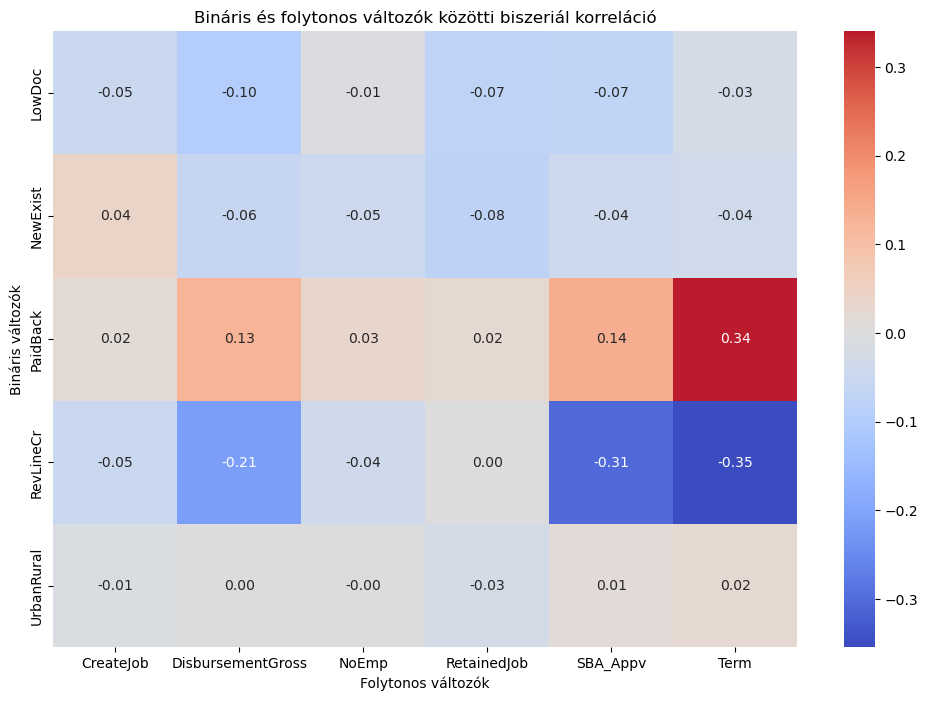

In [16]:
correlation_df = pd.DataFrame(correlation_data)
plt.figure(figsize=(12, 8))
correlation_matrix = correlation_df.pivot(index="Binary Variable", columns="Continuous Variable", values="Correlation Coefficient")
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Bináris és folytonos változók közötti biszeriál korreláció")
plt.xlabel('Folytonos változók')
plt.ylabel('Bináris változók')
plt.show()

In [17]:
describe_data(df_sba)

530630


,Column,type,unique sample,uniques,NaN%,Min,Max
0,State,object,"[NC, AR, CA, FL, LA]",51,0.0,None,None
1,NAICS,int64,"[44, 72, 61, 23, 53]",24,0.0,11,92
2,Term,int64,"[162, 126, 83, 84, 60]",337,0.0,0,569
3,NoEmp,int64,"[2, 7, 18, 4, 3]",406,0.0,0,8000
4,NewExist,int64,"[2, 1]",2,0.0,1,2
5,CreateJob,int64,"[0, 5, 4, 1, 20]",204,0.0,0,5085
6,RetainedJob,int64,"[0, 23, 4, 6, 1]",310,0.0,0,9500
7,UrbanRural,int64,"[1, 2]",2,0.0,1,2
8,RevLineCr,bool,"[False, True]",2,0.0,False,True
9,LowDoc,bool,"[False, True]",2,0.0,False,True


In [18]:
df_sba.to_csv('data_for_learning.csv', index=False)

In [19]:
def makeplot(variable1, variable2, variable3):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=variable1, y=variable2, hue=variable3)
    plt.title('Scatter plot by Paidback groups')
    plt.legend(title='Paidback')
    plt.grid(True)
    plt.show()

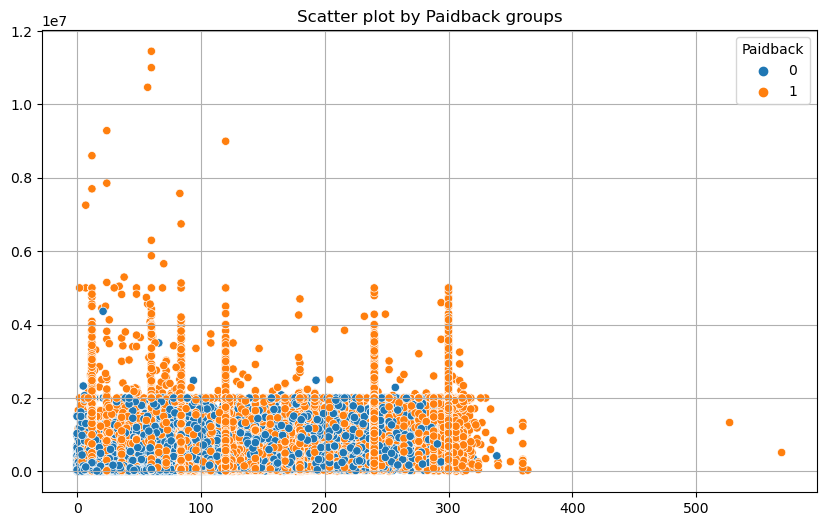

In [20]:
makeplot(df_sba['Term'].values, df_sba['DisbursementGross'].values , df_sba['PaidBack'].values)

In [21]:
df_sba

,State,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,SBA_Appv,PaidBack
12,NC,44,162,2,2,0,0,1,False,False,253400,190050,1
24,AR,72,126,7,1,0,0,1,False,False,137300,116705,1
28,CA,61,83,18,2,5,23,1,True,False,438541,50000,1
30,FL,23,84,4,1,0,4,1,True,False,51440,17500,1
32,LA,53,60,3,1,0,0,1,False,False,50000,42500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
863829,NV,23,240,20,1,15,0,1,False,False,509000,509000,1
863834,AZ,51,84,3,1,0,3,1,True,False,15635,5000,1
863852,IL,72,240,10,1,0,1,1,False,False,1038000,1038000,1
865073,MT,32,107,2,1,0,0,2,False,False,170000,127500,0


### Standardizálás

In [22]:
numeric_feature_names = ['Term', 'NoEmp', 'CreateJob','RetainedJob','DisbursementGross','SBA_Appv']
categoricial_feature_names = ['State','NAICS', 'NewExist','UrbanRural']

df_standardized = df_sba.copy()

ss = StandardScaler()
ss.fit(df_standardized[numeric_feature_names])
df_standardized[numeric_feature_names] = ss.transform(df_standardized[numeric_feature_names])
df_standardized = pd.get_dummies(df_standardized, columns=categoricial_feature_names)
categorical_engineered_features = list(set(df_standardized.columns) - set(numeric_feature_names))
print(categorical_engineered_features)

df_standardized

['State_MD', 'NAICS_54', 'NAICS_92', 'State_VA', 'NAICS_11', 'State_FL', 'State_OH', 'NAICS_62', 'State_WI', 'State_KS', 'State_ID', 'State_NH', 'State_DC', 'State_IA', 'NAICS_52', 'State_CO', 'NAICS_31', 'NAICS_48', 'State_WA', 'State_MN', 'State_TN', 'NAICS_51', 'State_LA', 'State_AZ', 'NewExist_1', 'NewExist_2', 'NAICS_49', 'State_UT', 'State_MI', 'NAICS_42', 'NAICS_21', 'State_MS', 'State_MT', 'State_TX', 'State_NV', 'NAICS_81', 'State_MO', 'State_WV', 'RevLineCr', 'NAICS_72', 'State_NY', 'State_IN', 'State_OR', 'State_KY', 'State_DE', 'State_NE', 'State_OK', 'State_ND', 'State_PA', 'NAICS_44', 'State_IL', 'UrbanRural_1', 'State_AK', 'NAICS_32', 'State_ME', 'State_SC', 'State_RI', 'NAICS_61', 'State_VT', 'NAICS_45', 'State_SD', 'PaidBack', 'State_NM', 'State_CA', 'State_MA', 'State_HI', 'UrbanRural_2', 'NAICS_33', 'State_NC', 'State_CT', 'LowDoc', 'NAICS_55', 'NAICS_22', 'State_NJ', 'NAICS_56', 'NAICS_23', 'NAICS_71', 'State_AL', 'State_GA', 'NAICS_53', 'State_WY', 'State_AR']


,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,SBA_Appv,PaidBack,State_AK,...,NAICS_61,NAICS_62,NAICS_71,NAICS_72,NAICS_81,NAICS_92,NewExist_1,NewExist_2,UrbanRural_1,UrbanRural_2
12,0.936903,-0.150286,-0.180372,-0.266334,False,False,0.193103,0.216879,1,0,...,0,0,0,0,0,0,0,1,1,0
24,0.424974,-0.039197,-0.180372,-0.266334,False,False,-0.179962,-0.075437,1,0,...,0,0,0,1,0,0,1,0,1,0
28,-0.186496,0.205201,0.195437,0.756516,True,False,0.788018,-0.341291,1,0,...,1,0,0,0,0,0,0,1,1,0
30,-0.172276,-0.105850,-0.180372,-0.088447,True,False,-0.455856,-0.470820,1,0,...,0,0,0,0,0,0,1,0,1,0
32,-0.513562,-0.128068,-0.180372,-0.266334,False,False,-0.460484,-0.371182,1,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863829,2.046082,0.249637,0.947053,-0.266334,False,False,1.014425,1.488056,1,0,...,0,0,0,0,0,0,1,0,1,0
863834,-0.172276,-0.128068,-0.180372,-0.132919,True,False,-0.570909,-0.520638,1,0,...,0,0,0,0,0,0,1,0,1,0
863852,2.046082,0.027457,-0.180372,-0.221862,False,False,2.714265,3.596389,1,0,...,0,0,0,1,0,0,1,0,1,0
865073,0.154789,-0.150286,-0.180372,-0.266334,False,False,-0.074887,-0.032414,0,0,...,0,0,0,0,0,0,1,0,0,1


### Normalizálás

In [23]:
df_normalized= df_sba.copy()
normalizer = MinMaxScaler()

df_normalized[numeric_feature_names] = normalizer.fit_transform(df_normalized[numeric_feature_names])
df_normalized = pd.get_dummies(df_normalized, columns=categoricial_feature_names)
categorical_engineered_features = list(set(df_normalized.columns) - set(numeric_feature_names))
print(categorical_engineered_features)
df_normalized

['State_MD', 'NAICS_54', 'NAICS_92', 'State_VA', 'NAICS_11', 'State_FL', 'State_OH', 'NAICS_62', 'State_WI', 'State_KS', 'State_ID', 'State_NH', 'State_DC', 'State_IA', 'NAICS_52', 'State_CO', 'NAICS_31', 'NAICS_48', 'State_WA', 'State_MN', 'State_TN', 'NAICS_51', 'State_LA', 'State_AZ', 'NewExist_1', 'NewExist_2', 'NAICS_49', 'State_UT', 'State_MI', 'NAICS_42', 'NAICS_21', 'State_MS', 'State_MT', 'State_TX', 'State_NV', 'NAICS_81', 'State_MO', 'State_WV', 'RevLineCr', 'NAICS_72', 'State_NY', 'State_IN', 'State_OR', 'State_KY', 'State_DE', 'State_NE', 'State_OK', 'State_ND', 'State_PA', 'NAICS_44', 'State_IL', 'UrbanRural_1', 'State_AK', 'NAICS_32', 'State_ME', 'State_SC', 'State_RI', 'NAICS_61', 'State_VT', 'NAICS_45', 'State_SD', 'PaidBack', 'State_NM', 'State_CA', 'State_MA', 'State_HI', 'UrbanRural_2', 'NAICS_33', 'State_NC', 'State_CT', 'LowDoc', 'NAICS_55', 'NAICS_22', 'State_NJ', 'NAICS_56', 'NAICS_23', 'NAICS_71', 'State_AL', 'State_GA', 'NAICS_53', 'State_WY', 'State_AR']


,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,SBA_Appv,PaidBack,State_AK,...,NAICS_61,NAICS_62,NAICS_71,NAICS_72,NAICS_81,NAICS_92,NewExist_1,NewExist_2,UrbanRural_1,UrbanRural_2
12,0.284710,0.000250,0.000000,0.000000,False,False,0.021796,0.042127,1,0,...,0,0,0,0,0,0,0,1,1,0
24,0.221441,0.000875,0.000000,0.000000,False,False,0.011650,0.025826,1,0,...,0,0,0,1,0,0,1,0,1,0
28,0.145870,0.002250,0.000983,0.002421,True,False,0.037977,0.011001,1,0,...,1,0,0,0,0,0,0,1,1,0
30,0.147627,0.000500,0.000000,0.000421,True,False,0.004146,0.003778,1,0,...,0,0,0,0,0,0,1,0,1,0
32,0.105448,0.000375,0.000000,0.000000,False,False,0.004020,0.009334,1,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863829,0.421793,0.002500,0.002950,0.000000,False,False,0.044134,0.113013,1,0,...,0,0,0,0,0,0,1,0,1,0
863834,0.147627,0.000375,0.000000,0.000316,True,False,0.001017,0.001000,1,0,...,0,0,0,0,0,0,1,0,1,0
863852,0.421793,0.001250,0.000000,0.000105,False,False,0.090366,0.230581,1,0,...,0,0,0,1,0,0,1,0,1,0
865073,0.188049,0.000250,0.000000,0.000000,False,False,0.014508,0.028225,0,0,...,0,0,0,0,0,0,1,0,0,1


### Skálázatlan adatok átalakítása

In [24]:
df_sba_dummies = pd.get_dummies(df_sba, columns=categoricial_feature_names)
categorical_engineered_features = list(set(df_sba_dummies.columns) - set(numeric_feature_names))
print(categorical_engineered_features)
df_sba_dummies

['State_MD', 'NAICS_54', 'NAICS_92', 'State_VA', 'NAICS_11', 'State_FL', 'State_OH', 'NAICS_62', 'State_WI', 'State_KS', 'State_ID', 'State_NH', 'State_DC', 'State_IA', 'NAICS_52', 'State_CO', 'NAICS_31', 'NAICS_48', 'State_WA', 'State_MN', 'State_TN', 'NAICS_51', 'State_LA', 'State_AZ', 'NewExist_1', 'NewExist_2', 'NAICS_49', 'State_UT', 'State_MI', 'NAICS_42', 'NAICS_21', 'State_MS', 'State_MT', 'State_TX', 'State_NV', 'NAICS_81', 'State_MO', 'State_WV', 'RevLineCr', 'NAICS_72', 'State_NY', 'State_IN', 'State_OR', 'State_KY', 'State_DE', 'State_NE', 'State_OK', 'State_ND', 'State_PA', 'NAICS_44', 'State_IL', 'UrbanRural_1', 'State_AK', 'NAICS_32', 'State_ME', 'State_SC', 'State_RI', 'NAICS_61', 'State_VT', 'NAICS_45', 'State_SD', 'PaidBack', 'State_NM', 'State_CA', 'State_MA', 'State_HI', 'UrbanRural_2', 'NAICS_33', 'State_NC', 'State_CT', 'LowDoc', 'NAICS_55', 'NAICS_22', 'State_NJ', 'NAICS_56', 'NAICS_23', 'NAICS_71', 'State_AL', 'State_GA', 'NAICS_53', 'State_WY', 'State_AR']


,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,SBA_Appv,PaidBack,State_AK,...,NAICS_61,NAICS_62,NAICS_71,NAICS_72,NAICS_81,NAICS_92,NewExist_1,NewExist_2,UrbanRural_1,UrbanRural_2
12,162,2,0,0,False,False,253400,190050,1,0,...,0,0,0,0,0,0,0,1,1,0
24,126,7,0,0,False,False,137300,116705,1,0,...,0,0,0,1,0,0,1,0,1,0
28,83,18,5,23,True,False,438541,50000,1,0,...,1,0,0,0,0,0,0,1,1,0
30,84,4,0,4,True,False,51440,17500,1,0,...,0,0,0,0,0,0,1,0,1,0
32,60,3,0,0,False,False,50000,42500,1,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863829,240,20,15,0,False,False,509000,509000,1,0,...,0,0,0,0,0,0,1,0,1,0
863834,84,3,0,3,True,False,15635,5000,1,0,...,0,0,0,0,0,0,1,0,1,0
863852,240,10,0,1,False,False,1038000,1038000,1,0,...,0,0,0,1,0,0,1,0,1,0
865073,107,2,0,0,False,False,170000,127500,0,0,...,0,0,0,0,0,0,1,0,0,1


### Standardizált adatok szétválasztása tanító és teszt adathalmazra

In [25]:
X_s = df_standardized.drop(columns=['PaidBack'])
y_s = df_standardized['PaidBack']
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=42)
print("Tanító adatok mérete (X):", X_train_s.shape)
print("Teszt adatok mérete (X):", X_test_s.shape)
print("Tanító adatok mérete (y):", y_train_s.shape)
print("Teszt adatok mérete (y):", y_test_s.shape)

Tanító adatok mérete (X): (424504, 87)
Teszt adatok mérete (X): (106126, 87)
Tanító adatok mérete (y): (424504,)
Teszt adatok mérete (y): (106126,)


### Normalizált adatok szétválasztása tanító és teszt adathalmazra

In [26]:
X_n = df_normalized.drop(columns=['PaidBack'])
y_n = df_normalized['PaidBack']
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.2, random_state=42)
print("Tanító adatok mérete (X):", X_train_n.shape)
print("Teszt adatok mérete (X):", X_test_n.shape)
print("Tanító adatok mérete (y):", y_train_n.shape)
print("Teszt adatok mérete (y):", y_test_n.shape)

Tanító adatok mérete (X): (424504, 87)
Teszt adatok mérete (X): (106126, 87)
Tanító adatok mérete (y): (424504,)
Teszt adatok mérete (y): (106126,)


### Skálázatlan adatok szétválasztása tanító és teszt adatokra

In [27]:
X_e = df_sba_dummies.drop(columns=['PaidBack'])
y_e = df_sba_dummies['PaidBack']
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size=0.2, random_state=42)
print("Tanító adatok mérete (X):", X_train_e.shape)
print("Teszt adatok mérete (X):", X_test_e.shape)
print("Tanító adatok mérete (y):", y_train_e.shape)
print("Teszt adatok mérete (y):", y_test_e.shape)

Tanító adatok mérete (X): (424504, 87)
Teszt adatok mérete (X): (106126, 87)
Tanító adatok mérete (y): (424504,)
Teszt adatok mérete (y): (106126,)


## Logisztikus regresszor modell

In [28]:
start_time_spec=time.time()
lr_s = LogisticRegression(max_iter=1000)
model_s = lr_s.fit(X_train_s, y_train_s)
end_time_spec=time.time()
training_time_lr_s=end_time_spec-start_time_spec
start_time_spec=time.time()
lr_n = LogisticRegression(max_iter=1000)
model_n = lr_n.fit(X_train_n, y_train_n)
end_time_spec=time.time()
training_time_lr_n=end_time_spec-start_time_spec
start_time_spec=time.time()
lr_e = LogisticRegression(max_iter=1000)
model_e = lr_e.fit(X_train_e, y_train_e)
end_time_spec=time.time()
training_time_lr_e=end_time_spec-start_time_spec

training_time_lr = training_time_lr_e+training_time_lr_s+training_time_lr_n
print(f"A tanítási idő: {training_time_lr:.2f} másodperc")

A tanítási idő: 35.96 másodperc


In [29]:
y_pred_s = lr_s.predict(X_test_s)
y_pred_n = lr_n.predict(X_test_n)
y_pred_e = lr_e.predict(X_test_e)
cm_s_lr = confusion_matrix(y_test_s, y_pred_s)
cm_n_lr = confusion_matrix(y_test_n, y_pred_n)
cm_e_lr = confusion_matrix(y_test_e, y_pred_e)
accuracy_s_lr = accuracy_score(y_test_s, y_pred_s)
accuracy_n_lr = accuracy_score(y_test_n, y_pred_n)
accuracy_e_lr = accuracy_score(y_test_e, y_pred_e)
precision_s_lr = precision_score(y_test_s, y_pred_s, average='weighted')
precision_n_lr = precision_score(y_test_n, y_pred_n, average='weighted')
precision_e_lr = precision_score(y_test_e, y_pred_e, average='weighted')
recall_s_lr = recall_score(y_test_s, y_pred_s, average='weighted')
recall_n_lr = recall_score(y_test_n, y_pred_n, average='weighted')
recall_e_lr = recall_score(y_test_e, y_pred_e, average='weighted')
f1_s_lr = f1_score(y_test_s, y_pred_s, average='weighted')
f1_n_lr = f1_score(y_test_n, y_pred_n, average='weighted')
f1_e_lr = f1_score(y_test_e, y_pred_e, average='weighted')
mse_s_lr = mean_squared_error(y_test_s, y_pred_s)
mse_n_lr = mean_squared_error(y_test_n, y_pred_n)
mse_e_lr = mean_squared_error(y_test_e, y_pred_e)

y_proba_s = lr_s.predict_proba(X_test_s)[:, 1]
y_proba_n = lr_n.predict_proba(X_test_n)[:, 1]
y_proba_e = lr_e.predict_proba(X_test_e)[:, 1]
roc_auc_s_lr = roc_auc_score(y_test_s, y_proba_s)
roc_auc_n_lr = roc_auc_score(y_test_n, y_proba_n)
roc_auc_e_lr = roc_auc_score(y_test_e, y_proba_e)

print("Skálázatlan adatok")
print(classification_report(y_test_e, y_pred_e))
print("Standardizált adatok")
print(classification_report(y_test_s, y_pred_s))
print('Normalizált adatok')
print(classification_report(y_test_n, y_pred_n))

Skálázatlan adatok
              precision    recall  f1-score   support

           0       0.39      0.01      0.02     24677
           1       0.77      0.99      0.87     81449

    accuracy                           0.77    106126
   macro avg       0.58      0.50      0.44    106126
weighted avg       0.68      0.77      0.67    106126

Standardizált adatok
              precision    recall  f1-score   support

           0       0.69      0.40      0.50     24677
           1       0.84      0.95      0.89     81449

    accuracy                           0.82    106126
   macro avg       0.76      0.67      0.70    106126
weighted avg       0.80      0.82      0.80    106126

Normalizált adatok
              precision    recall  f1-score   support

           0       0.69      0.39      0.49     24677
           1       0.84      0.95      0.89     81449

    accuracy                           0.82    106126
   macro avg       0.76      0.67      0.69    106126
weighted avg   

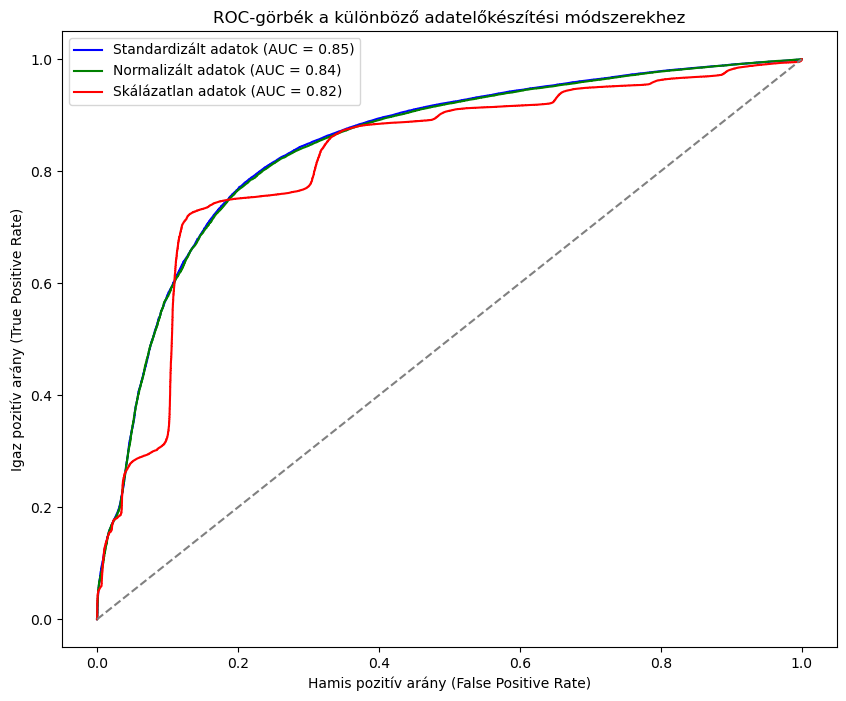

    Mérőszám  Skálázatlan adatok  Standardizált adatok  Normalizált adatok
0   Accuracy            0.766023              0.817745            0.816105
1  Precision            0.680734              0.802930            0.800860
2     Recall            0.766023              0.817745            0.816105
3   F1 Score            0.670550              0.798805            0.796132
4        MSE            0.233977              0.182255            0.183895
5        AUC            0.820684              0.845387            0.843617


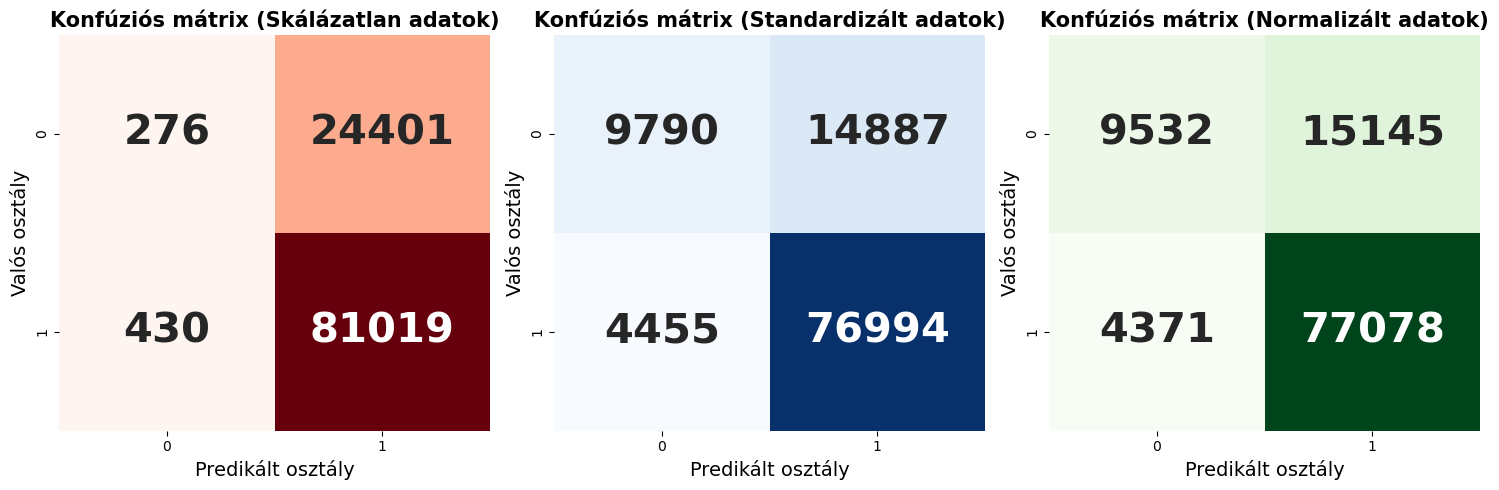

In [30]:
results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE", "AUC"],
    "Skálázatlan adatok": [accuracy_e_lr, precision_e_lr, recall_e_lr, f1_e_lr, mse_e_lr, roc_auc_e_lr],
    "Standardizált adatok": [accuracy_s_lr, precision_s_lr, recall_s_lr, f1_s_lr, mse_s_lr, roc_auc_s_lr],
    "Normalizált adatok": [accuracy_n_lr, precision_n_lr, recall_n_lr, f1_n_lr, mse_n_lr, roc_auc_n_lr]  
}

fpr_s, tpr_s, _ = roc_curve(y_test_s, y_proba_s)
fpr_n, tpr_n, _ = roc_curve(y_test_n, y_proba_n)
fpr_e, tpr_e, _ = roc_curve(y_test_e, y_proba_e)

plt.figure(figsize=(10, 8))
plt.plot(fpr_s, tpr_s, color='blue', label=f'Standardizált adatok (AUC = {roc_auc_s_lr:.2f})')
plt.plot(fpr_n, tpr_n, color='green', label=f'Normalizált adatok (AUC = {roc_auc_n_lr:.2f})')
plt.plot(fpr_e, tpr_e, color='red', label=f'Skálázatlan adatok (AUC = {roc_auc_e_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-görbék a különböző adatelőkészítési módszerekhez')
plt.xlabel('Hamis pozitív arány (False Positive Rate)')
plt.ylabel('Igaz pozitív arány (True Positive Rate)')
plt.legend()
plt.show()


results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_lr, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g',cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_lr, annot=True, cmap='Blues', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_lr, annot=True, cmap='Greens', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.tight_layout()
plt.show()

## Döntési fa modell

In [31]:
start_time_spec=time.time()
decision_tree_s = DecisionTreeClassifier()
decision_tree_s.fit(X_train_s, y_train_s)
end_time_spec=time.time()
training_time_df_s=end_time_spec-start_time_spec

start_time_spec=time.time()
decision_tree_n = DecisionTreeClassifier()
decision_tree_n.fit(X_train_n, y_train_n)
end_time_spec=time.time()
training_time_df_n=end_time_spec-start_time_spec

start_time_spec=time.time()
decision_tree_e = DecisionTreeClassifier()
decision_tree_e.fit(X_train_e, y_train_e)
end_time_spec=time.time()
training_time_df_e=end_time_spec-start_time_spec

training_time_df = training_time_df_e+training_time_df_s+training_time_df_n
print(f"A tanítási idő: {training_time_df:.2f} másodperc\n")

y_pred_s = decision_tree_s.predict(X_test_s)
y_pred_n = decision_tree_n.predict(X_test_n)
y_pred_e = decision_tree_e.predict(X_test_e)

accuracy_s_df = accuracy_score(y_test_s, y_pred_s)
accuracy_n_df = accuracy_score(y_test_n, y_pred_n)
accuracy_e_df = accuracy_score(y_test_e, y_pred_e)

precision_s_df = precision_score(y_test_s, y_pred_s, average='weighted')
precision_n_df = precision_score(y_test_n, y_pred_n, average='weighted')
precision_e_df = precision_score(y_test_e, y_pred_e, average='weighted')

recall_s_df = recall_score(y_test_s, y_pred_s, average='weighted')
recall_n_df = recall_score(y_test_n, y_pred_n, average='weighted')
recall_e_df = recall_score(y_test_e, y_pred_e, average='weighted')

f1_s_df = f1_score(y_test_s, y_pred_s, average='weighted')
f1_n_df = f1_score(y_test_n, y_pred_n, average='weighted')
f1_e_df = f1_score(y_test_e, y_pred_e, average='weighted')

mse_s_df = mean_squared_error(y_test_s, y_pred_s)
mse_n_df = mean_squared_error(y_test_n, y_pred_n)
mse_e_df = mean_squared_error(y_test_e, y_pred_e)

y_proba_s = decision_tree_s.predict_proba(X_test_s)[:, 1]
y_proba_n = decision_tree_n.predict_proba(X_test_n)[:, 1]
y_proba_e = decision_tree_e.predict_proba(X_test_e)[:, 1]
roc_auc_s_df = roc_auc_score(y_test_s, y_proba_s)
roc_auc_n_df = roc_auc_score(y_test_n, y_proba_n)
roc_auc_e_df = roc_auc_score(y_test_e, y_proba_e)

print("Skálázatlan adatok")
print(classification_report(y_test_e, y_pred_e))
print("Standardizált adatok")
print(classification_report(y_test_s, y_pred_s))
print("Normalizált adatok")
print(classification_report(y_test_n, y_pred_n))

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE", "AUC"],
    "Skálázatlan adatok": [accuracy_e_df, precision_e_df, recall_e_df, f1_e_df, mse_e_df, roc_auc_e_df],
    "Standardizált adatok": [accuracy_s_df, precision_s_df, recall_s_df, f1_s_df, mse_s_df, roc_auc_s_df],
    "Normalizált adatok": [accuracy_n_df, precision_n_df, recall_n_df, f1_n_df, mse_n_df, roc_auc_n_df]   
}

results_df = pd.DataFrame(results)
print(results_df)

A tanítási idő: 37.46 másodperc

Skálázatlan adatok
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     24677
           1       0.94      0.94      0.94     81449

    accuracy                           0.91    106126
   macro avg       0.87      0.87      0.87    106126
weighted avg       0.91      0.91      0.91    106126

Standardizált adatok
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     24677
           1       0.94      0.94      0.94     81449

    accuracy                           0.91    106126
   macro avg       0.87      0.87      0.87    106126
weighted avg       0.91      0.91      0.91    106126

Normalizált adatok
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     24677
           1       0.94      0.94      0.94     81449

    accuracy                           0.91    106126
   macro avg       0.87      0.87   

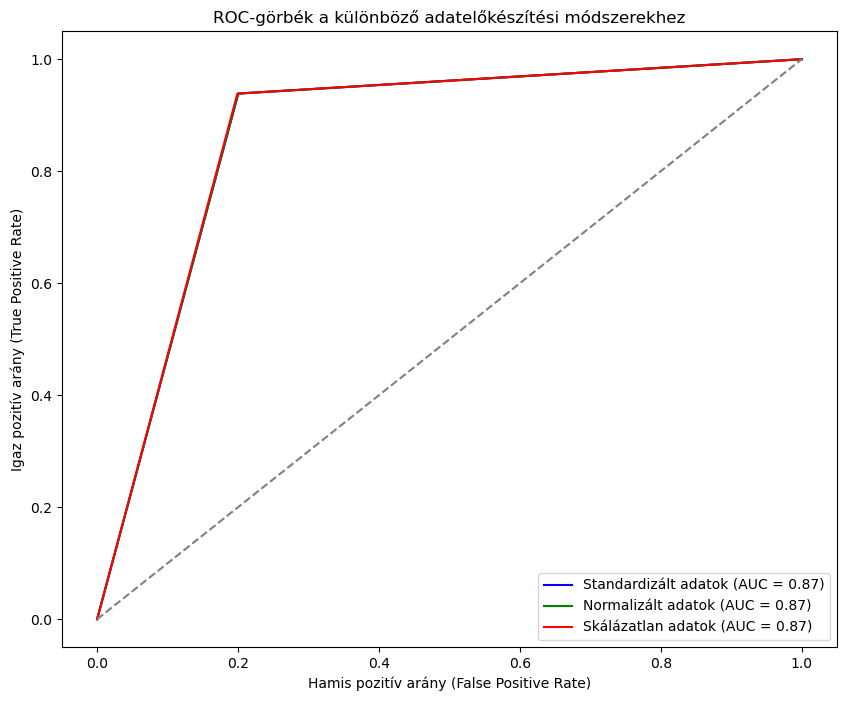

In [32]:
fpr_s, tpr_s, _ = roc_curve(y_test_s, y_proba_s)
fpr_n, tpr_n, _ = roc_curve(y_test_n, y_proba_n)
fpr_e, tpr_e, _ = roc_curve(y_test_e, y_proba_e)

plt.figure(figsize=(10, 8))
plt.plot(fpr_s, tpr_s, color='blue', label=f'Standardizált adatok (AUC = {roc_auc_s_df:.2f})')
plt.plot(fpr_n, tpr_n, color='green', label=f'Normalizált adatok (AUC = {roc_auc_n_df:.2f})')
plt.plot(fpr_e, tpr_e, color='red', label=f'Skálázatlan adatok (AUC = {roc_auc_e_df:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-görbék a különböző adatelőkészítési módszerekhez')
plt.xlabel('Hamis pozitív arány (False Positive Rate)')
plt.ylabel('Igaz pozitív arány (True Positive Rate)')
plt.legend()
plt.show()

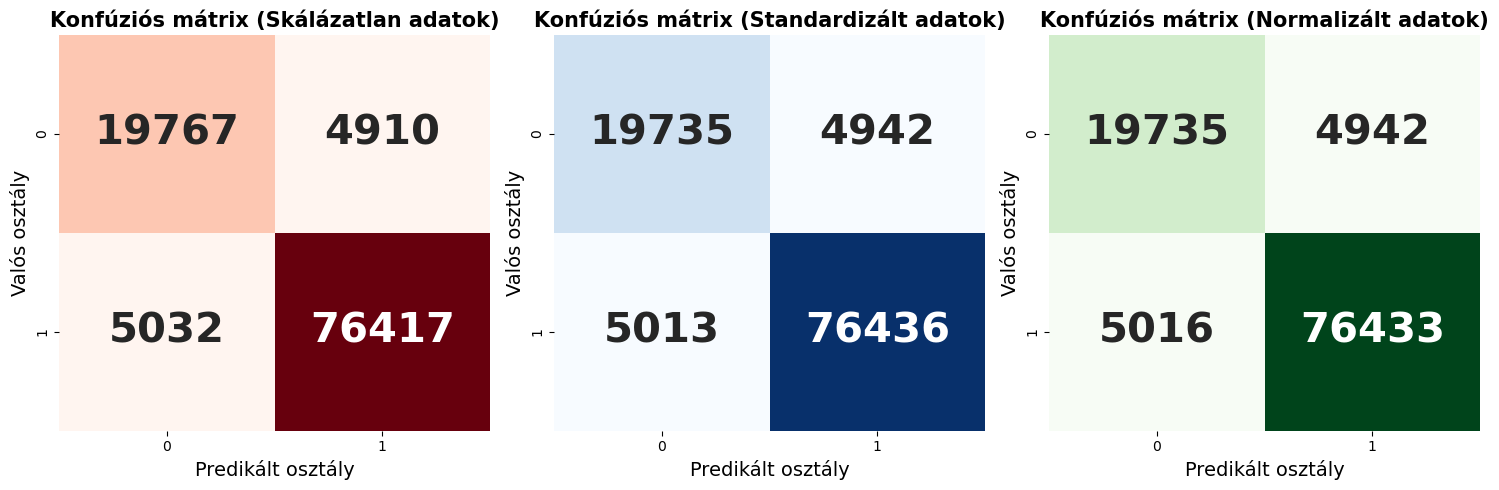

In [33]:
cm_s_df = confusion_matrix(y_test_s, y_pred_s)
cm_n_df = confusion_matrix(y_test_n, y_pred_n)
cm_e_df = confusion_matrix(y_test_e, y_pred_e)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_df, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g',cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_df, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_df, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.tight_layout()
plt.show()

## Regularizált döntési fa

In [34]:
param_space = {
    'max_depth': Categorical([None, 5, 10, 15]),
    'min_samples_split': Integer(2, 5),
    'min_samples_leaf': Integer(1, 5),
    'ccp_alpha': Real(0.0, 0.01)
}

opt = BayesSearchCV(
    estimator=DecisionTreeClassifier(),
    search_spaces=param_space,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

start_time_spec=time.time()
opt.fit(X_train_s, y_train_s)
end_time_spec=time.time()
training_time_rdf_s=end_time_spec-start_time_spec

best_params = opt.best_params_
print("Legjobb paraméterek Standardizált adatokon:", best_params)
best_model_rdf_s = opt.best_estimator_
y_pred_s = best_model_rdf_s.predict(X_test_s)
print("Standardizált adatokon a legjobb modell értékelése:")
print(classification_report(y_test_s, y_pred_s))
accuracy_s_rdf = accuracy_score(y_test_s, y_pred_s)
precision_s_rdf = precision_score(y_test_s, y_pred_s, average='weighted')
recall_s_rdf = recall_score(y_test_s, y_pred_s, average='weighted')
f1_s_rdf = f1_score(y_test_s, y_pred_s, average='weighted')
mse_s_rdf = mean_squared_error(y_test_s, y_pred_s)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
results = pd.DataFrame(opt.cv_results_)
results = results.sort_values(by='rank_test_score')
print("Paraméterkombinációk és rangsorolásuk táblázata Standardizált adatokon:")
print(results[['params', 'mean_test_score', 'rank_test_score']])

start_time_spec=time.time()
opt.fit(X_train_n, y_train_n)
end_time_spec=time.time()
training_time_rdf_n=end_time_spec-start_time_spec

best_params = opt.best_params_
print("Legjobb paraméterek Normalizált adatokon:", best_params)
best_model_rdf_n = opt.best_estimator_
y_pred_n = best_model_rdf_n.predict(X_test_n)
print("Normalizált adatokon a legjobb modell értékelése:")
print(classification_report(y_test_n, y_pred_n))
accuracy_n_rdf = accuracy_score(y_test_n, y_pred_n)
precision_n_rdf = precision_score(y_test_n, y_pred_n, average='weighted')
recall_n_rdf = recall_score(y_test_n, y_pred_n, average='weighted')
f1_n_rdf = f1_score(y_test_n, y_pred_n, average='weighted')
mse_n_rdf = mean_squared_error(y_test_n, y_pred_n)
results = pd.DataFrame(opt.cv_results_)
results = results.sort_values(by='rank_test_score')
print("Paraméterkombinációk és rangsorolásuk táblázata Normalizált adatokon:")
print(results[['params', 'mean_test_score', 'rank_test_score']])

start_time_spec=time.time()
opt.fit(X_train_e, y_train_e)
end_time_spec=time.time()
training_time_rdf_e=end_time_spec-start_time_spec

best_params = opt.best_params_
print("Legjobb paraméterek Skálázatlan adatokon:", best_params)
best_model_rdf_e = opt.best_estimator_
y_pred_e = best_model_rdf_e.predict(X_test_e)
print("Skálázatlan adatokon a legjobb modell értékelése:")
print(classification_report(y_test_e, y_pred_e))
accuracy_e_rdf = accuracy_score(y_test_e, y_pred_e)
precision_e_rdf = precision_score(y_test_e, y_pred_e, average='weighted')
recall_e_rdf = recall_score(y_test_e, y_pred_e, average='weighted')
f1_e_rdf = f1_score(y_test_e, y_pred_e, average='weighted')
mse_e_rdf = mean_squared_error(y_test_e, y_pred_e)
results = pd.DataFrame(opt.cv_results_)
results = results.sort_values(by='rank_test_score')
print("Paraméterkombinációk és rangsorolásuk táblázata Skálázatlan adatokon:")
print(results[['params', 'mean_test_score', 'rank_test_score']])

training_time_rdf = training_time_rdf_s+training_time_rdf_n+training_time_rdf_e
print(f"A tanítási idő: {training_time_rdf:.2f} másodperc")


y_proba_s = best_model_rdf_s.predict_proba(X_test_s)[:, 1]
y_proba_n = best_model_rdf_n.predict_proba(X_test_n)[:, 1]
y_proba_e = best_model_rdf_e.predict_proba(X_test_e)[:, 1]
roc_auc_s_rdf = roc_auc_score(y_test_s, y_proba_s)
roc_auc_n_rdf = roc_auc_score(y_test_n, y_proba_n)
roc_auc_e_rdf = roc_auc_score(y_test_e, y_proba_e)

Legjobb paraméterek Standardizált adatokon: OrderedDict([('ccp_alpha', 3.630307254743227e-05), ('max_depth', 15), ('min_samples_leaf', 4), ('min_samples_split', 3)])
Standardizált adatokon a legjobb modell értékelése:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     24677
           1       0.95      0.95      0.95     81449

    accuracy                           0.93    106126
   macro avg       0.90      0.90      0.90    106126
weighted avg       0.93      0.93      0.93    106126

Paraméterkombinációk és rangsorolásuk táblázata Standardizált adatokon:
                                                                                                   params  \
9    {'ccp_alpha': 3.630307254743227e-05, 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 3}   
23                     {'ccp_alpha': 0.0, 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5}   
58                     {'ccp_alpha': 0.0, 'max_depth': 1

In [35]:
results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE", "AUC"],
    "Skálázatlan adatok": [accuracy_e_rdf, precision_e_rdf, recall_e_rdf, f1_e_rdf, mse_e_rdf, roc_auc_e_rdf],
    "Standardizált adatok": [accuracy_s_rdf, precision_s_rdf, recall_s_rdf, f1_s_rdf, mse_s_rdf, roc_auc_s_rdf],
    "Normalizált adatok": [accuracy_n_rdf, precision_n_rdf, recall_n_rdf, f1_n_rdf, mse_n_rdf, roc_auc_n_rdf]   
}
results_df = pd.DataFrame(results)
print(results_df)

    Mérőszám  Skálázatlan adatok  Standardizált adatok  Normalizált adatok
0   Accuracy            0.930413              0.928048            0.930498
1  Precision            0.931051              0.928046            0.930984
2     Recall            0.930413              0.928048            0.930498
3   F1 Score            0.930695              0.928047            0.930718
4        MSE            0.069587              0.071952            0.069502
5        AUC            0.966550              0.965186            0.967523


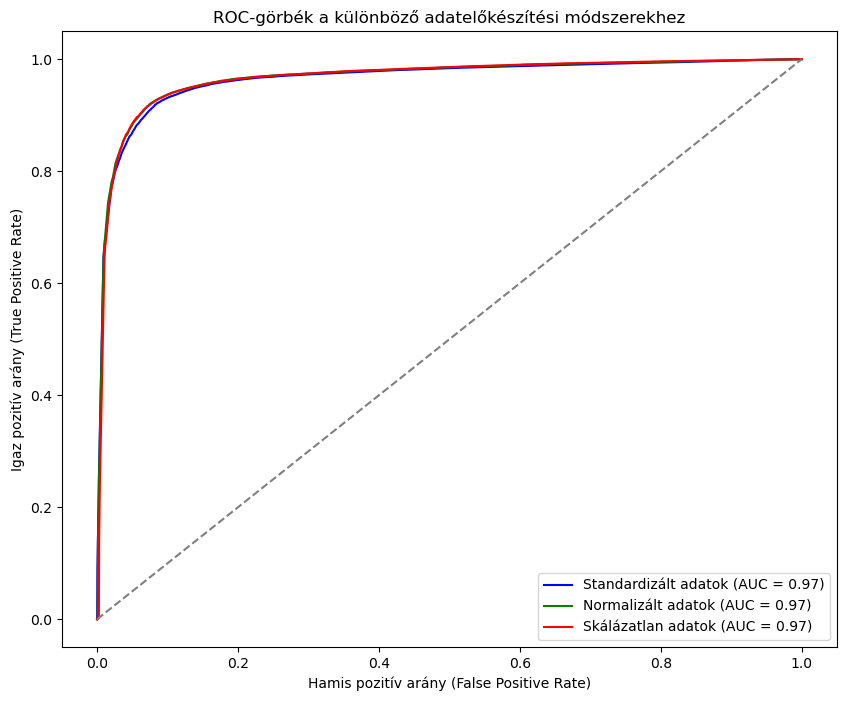

In [36]:
fpr_s, tpr_s, _ = roc_curve(y_test_s, y_proba_s)
fpr_n, tpr_n, _ = roc_curve(y_test_n, y_proba_n)
fpr_e, tpr_e, _ = roc_curve(y_test_e, y_proba_e)

plt.figure(figsize=(10, 8))
plt.plot(fpr_s, tpr_s, color='blue', label=f'Standardizált adatok (AUC = {roc_auc_s_rdf:.2f})')
plt.plot(fpr_n, tpr_n, color='green', label=f'Normalizált adatok (AUC = {roc_auc_n_rdf:.2f})')
plt.plot(fpr_e, tpr_e, color='red', label=f'Skálázatlan adatok (AUC = {roc_auc_e_rdf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-görbék a különböző adatelőkészítési módszerekhez')
plt.xlabel('Hamis pozitív arány (False Positive Rate)')
plt.ylabel('Igaz pozitív arány (True Positive Rate)')
plt.legend()
plt.show()

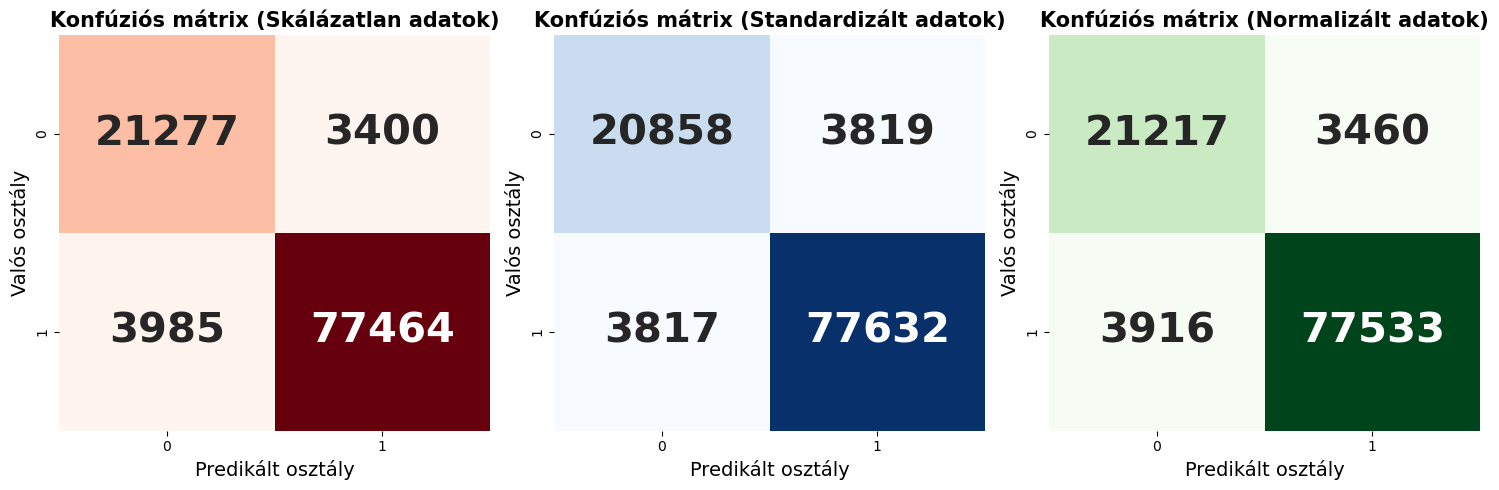

In [37]:
cm_s_rdf = confusion_matrix(y_test_s, y_pred_s)
cm_n_rdf = confusion_matrix(y_test_n, y_pred_n)
cm_e_rdf = confusion_matrix(y_test_e, y_pred_e)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_rdf, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g',cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_rdf, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_rdf, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.tight_layout()
plt.show()

## Gradiens turbózás K-fold keresztvalidációval és korai leállással 

In [393]:
params_s = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'num_leaves': 31, 
    'max_bin': 255,
    'learning_rate': 0.1,
    'metric': ['binary_logloss', 'auc'],
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 4,
    'lambda_l1': 3.630307254743227e-05,
    'min_samples_split': 3, 
    'max_depth': 15,
}

params_n = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'num_leaves': 31, 
    'max_bin': 255,
    'learning_rate': 0.1,
    'metric': ['binary_logloss', 'auc'],
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 2,
    'lambda_l1': 1.1940491642078446e-05,
    'min_samples_split': 4
}

params_e = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'num_leaves': 31, 
    'max_bin': 255,
    'learning_rate': 0.1,
    'metric': ['binary_logloss', 'auc'], 
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 5,
    'lambda_l1': 7.2596021044690775e-06,
    'min_samples_split': 5
}

In [394]:
def experiment(objective, label_type, x_train, x_test, y_train, y_test, params, i, fajl):
    lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False)
    lgb_test = lgb.Dataset(x_test, y_test, free_raw_data=False)    
    params['objective'] = objective
    fajlnev = f"{fajl}_gbmodel.txt"
    if i == 0:
        gbm = lgb.train(
            params=params, 
            train_set=lgb_train, 
            valid_sets=[lgb_train, lgb_test],
            num_boost_round=10
        ) 
        gbm.save_model(fajlnev)
    else:
        gbmprev = lgb.Booster(model_file=fajlnev) 
        gbm = lgb.train(
            params=params,
            train_set=lgb_train,
            valid_sets=[lgb_train, lgb_test],
            num_boost_round=10,
            init_model=gbmprev
        ) 
        gbm.save_model(fajlnev) 
      
    y_fitted = pd.Series(gbm.predict(x_test, num_iteration=gbm.best_iteration))
    y_pred = pd.DataFrame({'y_pred': y_fitted})
    y_true = pd.DataFrame({'y': y_test})
    return pd.concat([y_true.reset_index(drop=True), y_pred], axis=1)

In [395]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
primary_target = 'binary'
tree_num = 100

def run_experiment(X, y, params, fajl):
    A = []
    accuracy = []
    previous_score = 0
    early_stopping_rounds = 5
    no_improvement = 0
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{num_folds}")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        for k in range(tree_num):
            if no_improvement < early_stopping_rounds:
                result = experiment(primary_target, 'binary', X_train, X_test, y_train, y_test, params, k, fajl)
                A.append(result)
                current_score = accuracy_score(result['y'], result['y_pred'].round())
                accuracy.append({
                    'current': current_score,
                    'previous': previous_score,
                    'no_improvement': no_improvement,
                    'early_stopping_rounds': early_stopping_rounds,
                    'no_improvement_s < early_stopping_rounds': no_improvement < early_stopping_rounds
                })
                if current_score > previous_score:
                    previous_score = current_score
                    no_improvement = 0
                else:
                    no_improvement += 1
            else:
                print("Korai leállás")
                break

    return A, accuracy

start_time_spec=time.time()
A_s, accuracy_s = run_experiment(X_s, y_s, params_s, "s")
end_time_spec=time.time()
training_time_gt_s=end_time_spec-start_time_spec
start_time_spec=time.time()
A_n, accuracy_n = run_experiment(X_n, y_n, params_n, "n")
end_time_spec=time.time()
training_time_gt_n=end_time_spec-start_time_spec
start_time_spec=time.time()
A_e, accuracy_e = run_experiment(X_e, y_e, params_e, "e")
end_time_spec=time.time()
training_time_gt_e=end_time_spec-start_time_spec
end_time = time.time()
training_time_gt = training_time_gt_e+training_time_gt_s+training_time_gt_n

Fold 1/5
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of posi

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy ma

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of posi

Korai leállás
Fold 2/5
Korai leállás
Fold 3/5
Korai leállás
Fold 4/5
Korai leállás
Fold 5/5
Korai leállás
Fold 1/5
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.766582 -> initscore=1.189109
[LightGBM] [Info] Start training from score 1.189109
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM]

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM]

In [396]:
print(f"A tanítási idő: {training_time_gt:.2f} másodperc")

A tanítási idő: 456.36 másodperc


Skálázatlan adatok


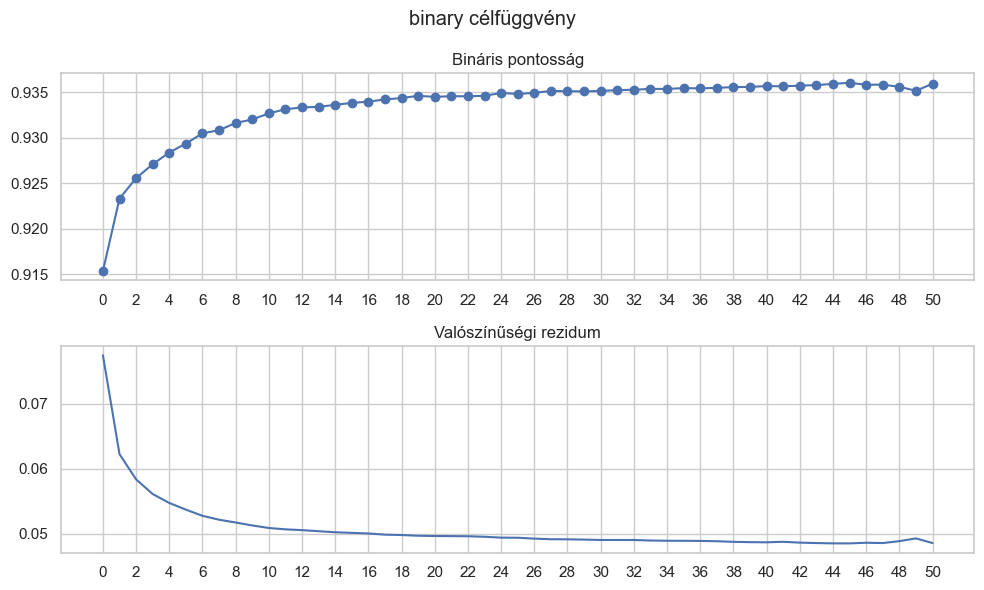

Standardizált adatok


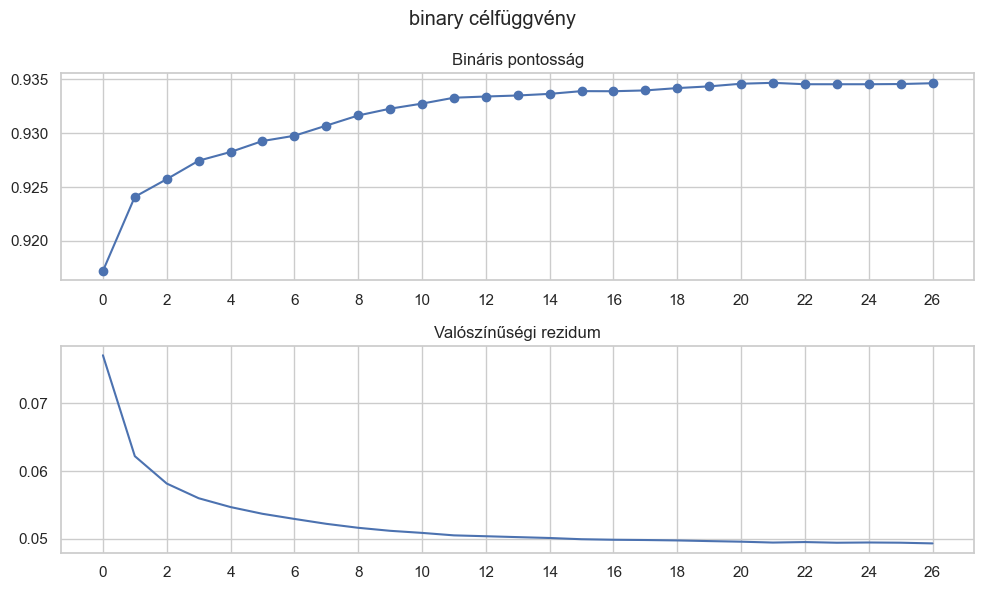

Normalizált adatok


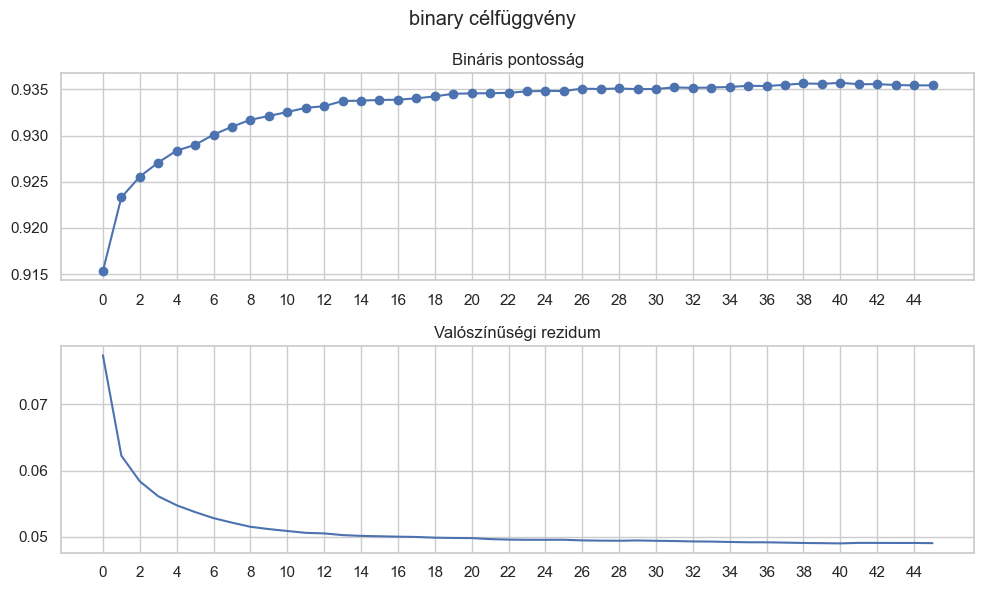

In [397]:
accuracy_binary = lambda D: [accuracy_score(x['y'], x['y_pred'].round()) for x in D]
accuracy_mean = lambda D: [mean_squared_error(x['y'], x['y_pred']) for x in D]

def accplot(accdata, objective):
    fig = plt.figure(figsize=(10,6))
    ax2 = fig.add_subplot(2,1,2)
    ax1 = fig.add_subplot(2,1,1, sharex=ax2) 
    fig.suptitle(objective + ' célfüggvény')
    ax1.plot(accuracy_binary(accdata), '-ob')
    ax1.set_title('Bináris pontosság')
    ax2.plot(accuracy_mean(accdata))
    ax2.set_title('Valószínűségi rezidum')
    ticks = np.arange(0, len(accdata))
    plt.xticks(ticks[::2], ticks[::2])
    plt.tight_layout()
    plt.show()
    
print('Skálázatlan adatok')
accplot(A_e, 'binary')
print('Standardizált adatok')
accplot(A_s, 'binary')
print('Normalizált adatok')
accplot(A_n, 'binary')

In [398]:
print(len(A_e))
print(len(A_s))
print(len(A_n))

51
27
46


In [400]:
y_pred_binary_s = (A_s[-6]['y_pred']>= 0.5).astype(int)
y_pred_binary_n = (A_n[-6]['y_pred']>= 0.5).astype(int)
y_pred_binary_e = (A_e[-6]['y_pred']>= 0.5).astype(int)
y_real_s = A_s[-6]['y']
y_real_n = A_n[-6]['y']
y_real_e = A_e[-6]['y']
y_proba_s = A_s[-6]['y_pred'].values
y_proba_n = A_s[-6]['y_pred'].values
y_proba_e = A_s[-6]['y_pred'].values

accuracy_s_gt = accuracy_score(y_real_s, y_pred_binary_s)
accuracy_n_gt = accuracy_score(y_real_n, y_pred_binary_n)
accuracy_e_gt = accuracy_score(y_real_e, y_pred_binary_e)

precision_s_gt = precision_score(y_real_s, y_pred_binary_s, average='weighted')
precision_n_gt = precision_score(y_real_n,  y_pred_binary_n, average='weighted')
precision_e_gt = precision_score(y_real_e, y_pred_binary_e, average='weighted')

recall_s_gt = recall_score(y_real_s, y_pred_binary_s, average='weighted')
recall_n_gt = recall_score(y_real_n,  y_pred_binary_n, average='weighted')
recall_e_gt = recall_score(y_real_e, y_pred_binary_e, average='weighted')

f1_s_gt = f1_score(y_real_s, y_pred_binary_s, average='weighted')
f1_n_gt = f1_score(y_real_n, y_pred_binary_n, average='weighted')
f1_e_gt = f1_score(y_real_e, y_pred_binary_e, average='weighted')

mse_s_gt = mean_squared_error(y_real_s, y_pred_binary_s)
mse_n_gt = mean_squared_error(y_real_n, y_pred_binary_n)
mse_e_gt = mean_squared_error(y_real_e, y_pred_binary_e)

roc_auc_s_gt = roc_auc_score(y_test_s, y_proba_s)
roc_auc_n_gt = roc_auc_score(y_test_n, y_proba_n)
roc_auc_e_gt = roc_auc_score(y_test_e, y_proba_e)

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE", "AUC"],
    "Skálázatlan adatok": [accuracy_e_gt, precision_e_gt, recall_e_gt, f1_e_gt, mse_e_gt, roc_auc_e_gt],
    "Standardizált adatok": [accuracy_s_gt, precision_s_gt, recall_s_gt, f1_s_gt, mse_s_gt, roc_auc_s_gt],
    "Normalizált adatok": [accuracy_n_gt, precision_n_gt, recall_n_gt, f1_n_gt, mse_n_gt, roc_auc_n_gt]   
}

results_df = pd.DataFrame(results)
print(results_df)

    Mérőszám  Skálázatlan adatok  Standardizált adatok  Normalizált adatok
0   Accuracy            0.936048              0.934691            0.935718
1  Precision            0.935866              0.934434            0.935495
2     Recall            0.936048              0.934691            0.935718
3   F1 Score            0.935952              0.934553            0.935599
4        MSE            0.063952              0.065309            0.064282
5        AUC            0.500938              0.500938            0.500938


In [401]:
cm_s_gt = confusion_matrix(y_real_s, y_pred_binary_s)
cm_n_gt = confusion_matrix(y_real_n, y_pred_binary_n)
cm_e_gt = confusion_matrix(y_real_e, y_pred_binary_e)

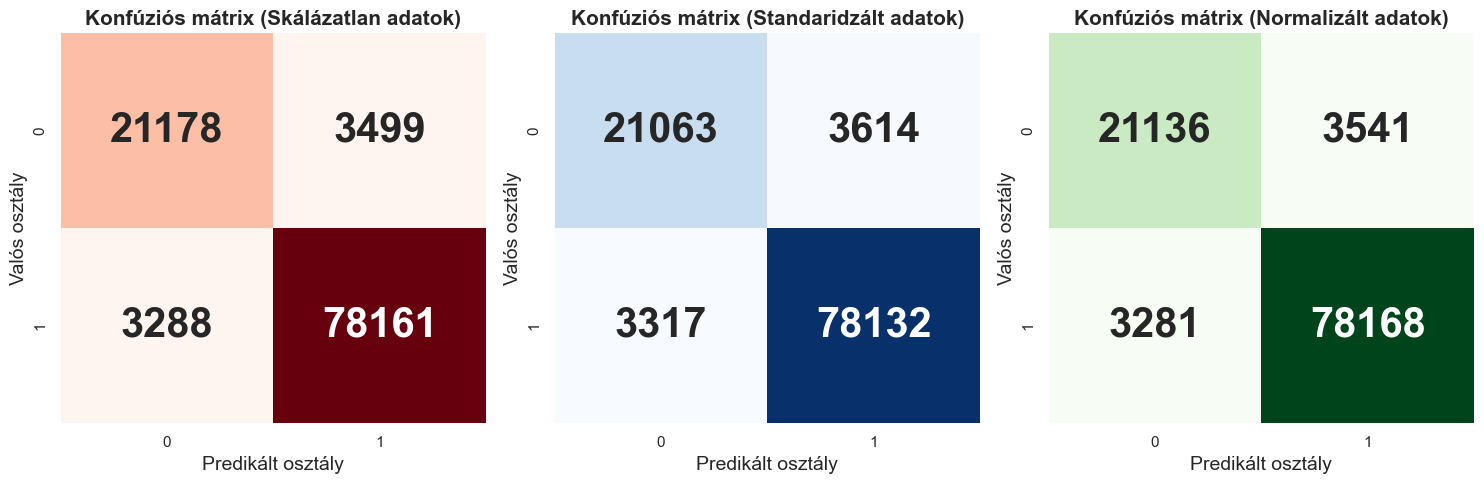

In [402]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_gt, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_gt, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Standaridzált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_gt, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.tight_layout()
plt.show()

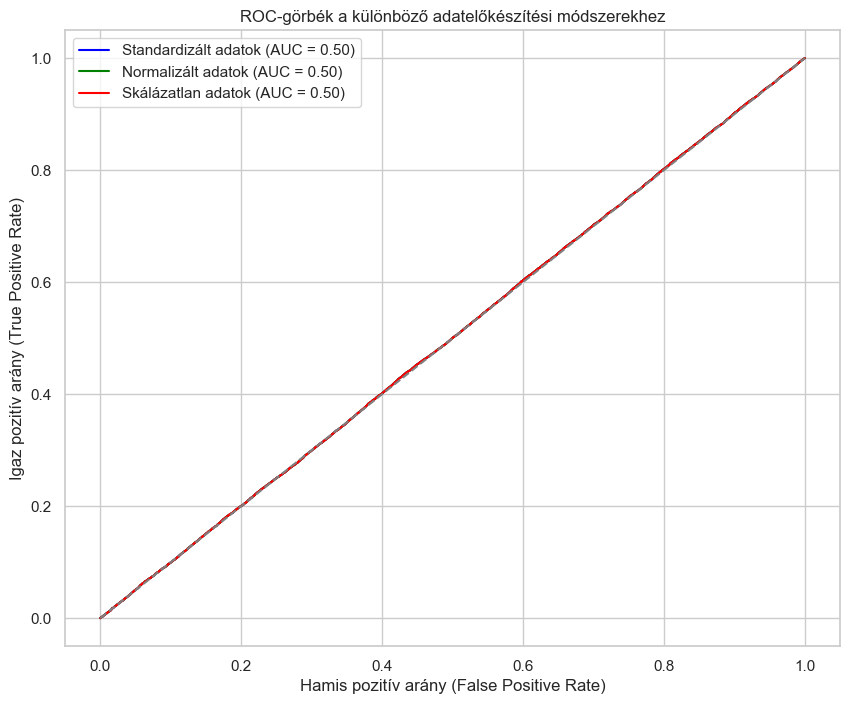

In [403]:
fpr_s, tpr_s, _ = roc_curve(y_test_s, y_proba_s)
fpr_n, tpr_n, _ = roc_curve(y_test_n, y_proba_n)
fpr_e, tpr_e, _ = roc_curve(y_test_e, y_proba_e)

plt.figure(figsize=(10, 8))
plt.plot(fpr_s, tpr_s, color='blue', label=f'Standardizált adatok (AUC = {roc_auc_s_gt:.2f})')
plt.plot(fpr_n, tpr_n, color='green', label=f'Normalizált adatok (AUC = {roc_auc_n_gt:.2f})')
plt.plot(fpr_e, tpr_e, color='red', label=f'Skálázatlan adatok (AUC = {roc_auc_e_gt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-görbék a különböző adatelőkészítési módszerekhez')
plt.xlabel('Hamis pozitív arány (False Positive Rate)')
plt.ylabel('Igaz pozitív arány (True Positive Rate)')
plt.legend()
plt.show()

## Neurális háló Keras

In [51]:
def check_and_convert_data(data):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    return data.astype(np.float32)

def create_and_train_model(X_train, y_train, X_test, y_test):
    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)
    
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train_cat, epochs=50, batch_size=32, verbose=0)
    
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    return model, y_pred, y_pred_prob 

X_train_s = check_and_convert_data(X_train_s)
X_test_s = check_and_convert_data(X_test_s)
X_train_n = check_and_convert_data(X_train_n)
X_test_n = check_and_convert_data(X_test_n)
X_train_e = check_and_convert_data(X_train_e)
X_test_e = check_and_convert_data(X_test_e)

y_train_s = np.array(y_train_s)
y_test_s = np.array(y_test_s)
y_train_n = np.array(y_train_n)
y_test_n = np.array(y_test_n)
y_train_e = np.array(y_train_e)
y_test_e = np.array(y_test_e)

start_time_spec = time.time()
model_s, y_pred_s_nn, y_proba_s_nn = create_and_train_model(X_train_s, y_train_s, X_test_s, y_test_s)
end_time_spec = time.time()
training_time_nn_s = end_time_spec - start_time_spec

start_time_spec = time.time()
model_n, y_pred_n_nn, y_proba_n_nn = create_and_train_model(X_train_n, y_train_n, X_test_n, y_test_n)
end_time_spec = time.time()
training_time_nn_n = end_time_spec - start_time_spec

start_time_spec = time.time()
model_e, y_pred_e_nn, y_proba_e_nn = create_and_train_model(X_train_e, y_train_e, X_test_e, y_test_e)
end_time_spec = time.time()
training_time_nn_e = end_time_spec - start_time_spec

training_time_nn = training_time_nn_e + training_time_nn_s + training_time_nn_n
print(f"A tanítási idő: {training_time_nn:.2f} másodperc")

accuracy_s_nn = accuracy_score(y_test_s, y_pred_s_nn)
accuracy_n_nn = accuracy_score(y_test_n, y_pred_n_nn)
accuracy_e_nn = accuracy_score(y_test_e, y_pred_e_nn)

precision_s_nn = precision_score(y_test_s, y_pred_s_nn, average='weighted')
precision_n_nn = precision_score(y_test_n, y_pred_n_nn, average='weighted')
precision_e_nn = precision_score(y_test_e, y_pred_e_nn, average='weighted')

recall_s_nn = recall_score(y_test_s, y_pred_s_nn, average='weighted')
recall_n_nn = recall_score(y_test_n, y_pred_n_nn, average='weighted')
recall_e_nn = recall_score(y_test_e, y_pred_e_nn, average='weighted')

f1_s_nn = f1_score(y_test_s, y_pred_s_nn, average='weighted')
f1_n_nn = f1_score(y_test_n, y_pred_n_nn, average='weighted')
f1_e_nn = f1_score(y_test_e, y_pred_e_nn, average='weighted')

mse_s_nn = mean_squared_error(y_test_s, y_pred_s_nn)
mse_n_nn = mean_squared_error(y_test_n, y_pred_n_nn)
mse_e_nn = mean_squared_error(y_test_e, y_pred_e_nn)

y_test_s_cat = to_categorical(y_test_s, num_classes=len(np.unique(y_train_s)))
y_test_n_cat = to_categorical(y_test_n, num_classes=len(np.unique(y_train_n)))
y_test_e_cat = to_categorical(y_test_e, num_classes=len(np.unique(y_train_e)))


roc_auc_s_nn = roc_auc_score(y_test_s_cat, y_proba_s_nn, multi_class='ovr')
roc_auc_n_nn = roc_auc_score(y_test_n_cat, y_proba_n_nn, multi_class='ovr')
roc_auc_e_nn = roc_auc_score(y_test_e_cat, y_proba_e_nn, multi_class='ovr')

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE", "ROC AUC"],
    "Skálázatlan adatok": [accuracy_e_nn, precision_e_nn, recall_e_nn, f1_e_nn, mse_e_nn, roc_auc_e_nn],
    "Standardizált adatok": [accuracy_s_nn, precision_s_nn, recall_s_nn, f1_s_nn, mse_s_nn, roc_auc_s_nn],
    "Normalizált adatok": [accuracy_n_nn, precision_n_nn, recall_n_nn, f1_n_nn, mse_n_nn, roc_auc_n_nn]   
}

results_df = pd.DataFrame(results)
print(results_df)


3317/3317 ━━━━━━━━━━━━━━━━━━━━ 3s 980us/step
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 3s 853us/step
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 3s 991us/step
A tanítási idő: 2609.56 másodperc
    Mérőszám  Skálázatlan adatok  Standardizált adatok  Normalizált adatok
0   Accuracy            0.767475              0.902399            0.894785
1  Precision            0.589017              0.902530            0.893287
2     Recall            0.767475              0.902399            0.894785
3   F1 Score            0.666507              0.902464            0.893899
4        MSE            0.232525              0.097601            0.105215
5    ROC AUC            0.499980              0.952968            0.941132


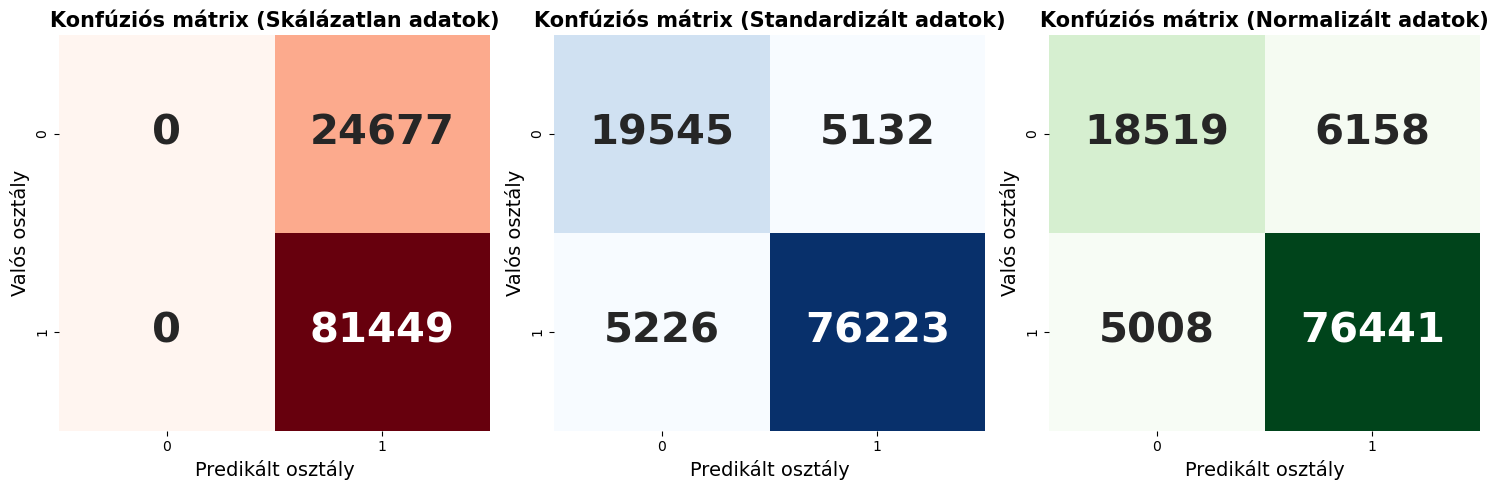

In [52]:
cm_s_nn = confusion_matrix(y_test_s, y_pred_s_nn)
cm_n_nn = confusion_matrix(y_test_n, y_pred_n_nn)
cm_e_nn = confusion_matrix(y_test_e, y_pred_e_nn)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_nn, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_nn, annot=True, cmap='Blues', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_nn, annot=True, cmap='Greens', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.tight_layout()
plt.show()

In [57]:
y_proba_s_nn= np.argmax(y_proba_s_nn, axis=1)
y_proba_n_nn = np.argmax(y_proba_n_nn, axis=1)
y_proba_e_nn = np.argmax(y_proba_e_nn, axis=1)

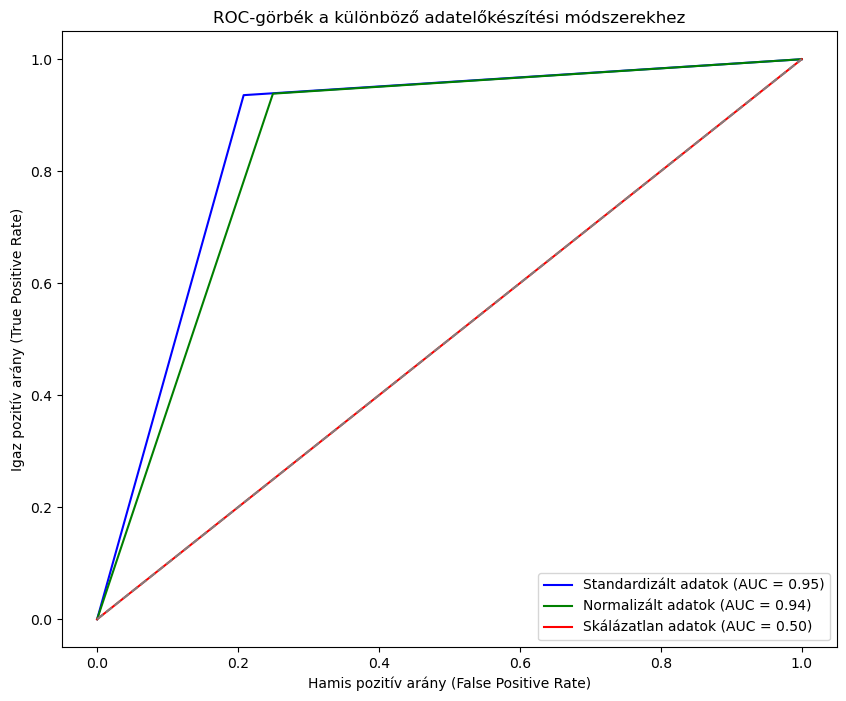

In [59]:
fpr_s, tpr_s, _ = roc_curve(y_test_s, y_proba_s_nn)
fpr_n, tpr_n, _ = roc_curve(y_test_n, y_proba_n_nn)
fpr_e, tpr_e, _ = roc_curve(y_test_e, y_proba_e_nn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_s, tpr_s, color='blue', label=f'Standardizált adatok (AUC = {roc_auc_s_nn:.2f})')
plt.plot(fpr_n, tpr_n, color='green', label=f'Normalizált adatok (AUC = {roc_auc_n_nn:.2f})')
plt.plot(fpr_e, tpr_e, color='red', label=f'Skálázatlan adatok (AUC = {roc_auc_e_nn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-görbék a különböző adatelőkészítési módszerekhez')
plt.xlabel('Hamis pozitív arány (False Positive Rate)')
plt.ylabel('Igaz pozitív arány (True Positive Rate)')
plt.legend()
plt.show()

## SVM

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}

grid_s = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

start_time_spec=time.time()
grid_s.fit(X_train_s, y_train_s)
end_time_spec=time.time()
training_time_svm_s=end_time_spec-start_time_spec

print(grid_s.best_params_)
print(grid_s.best_estimator_)

y_pred_s_svm = grid_s.predict(X_test_s)
y_proba_s = grid_s.predict_proba(X_test_s)[:, 1]

grid_n = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

start_time_spec=time.time()
grid_n.fit(X_train_n, y_train_n)
end_time_spec=time.time()
training_time_svm_s=end_time_spec-start_time_spec

print(grid_n.best_params_)
print(grid_n.best_estimator_)

y_pred_n_svm = grid_n.predict(X_test_n)
y_proba_n = grid_n.predict_proba(X_test_n)[:, 1]

grid_e = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

start_time_spec=time.time()
grid_e.fit(X_train_e, y_train_e)
end_time_spec=time.time()
training_time_svm_s=end_time_spec-start_time_spec

print(grid_e.best_params_)
print(grid_e.best_estimator_)

y_pred_e_svm = grid_e.predict(X_test_e)
y_proba_e = grid_e.predict_proba(X_test_e)[:, 1]

training_time_svm=training_time_svm_s+training_time_svm_n+training_time_svm_e
print(f"A tanítási idő: {training_time_svm:.2f} másodperc")

accuracy_s_svm = accuracy_score(y_test_s, y_pred_s_svm)
accuracy_n_svm = accuracy_score(y_test_n, y_pred_n_svm)
accuracy_e_svm = accuracy_score(y_test_e, y_pred_e_svm)

precision_s_svm = precision_score(y_test_s, y_pred_s_svm, average='weighted')
precision_n_svm = precision_score(y_test_n, y_pred_n_svm, average='weighted')
precision_e_svm = precision_score(y_test_e, y_pred_e_svm, average='weighted')

recall_s_svm = recall_score(y_test_s, y_pred_s_svm, average='weighted')
recall_n_svm = recall_score(y_test_n, y_pred_n_svm, average='weighted')
recall_e_svm = recall_score(y_test_e, y_pred_e_svm, average='weighted')

f1_s_svm = f1_score(y_test_s, y_pred_s_svm, average='weighted')
f1_n_svm = f1_score(y_test_n, y_pred_n_svm, average='weighted')
f1_e_svm = f1_score(y_test_e, y_pred_e_svm, average='weighted')

mse_s_svm = mean_squared_error(y_test_s, y_pred_s_svm)
mse_n_svm = mean_squared_error(y_test_n, y_pred_n_svm)
mse_e_svm = mean_squared_error(y_test_e, y_pred_e_svm)

roc_auc_s_svm = roc_auc_score(y_test_s, y_proba_s)
roc_auc_n_svm = roc_auc_score(y_test_n, y_proba_n)
roc_auc_e_svm = roc_auc_score(y_test_e, y_proba_e)

print("Skálázatlan adatok")
print(classification_report(y_test_e, y_pred_e_svm))
print("Standardizált adatok")
print(classification_report(y_test_s, y_pred_s_svm))
print("Normalizált adatok")
print(classification_report(y_test_n, y_pred_n_svm))

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE", "AUC"],
    "Skálázatlan adatok": [accuracy_e_svm, precision_e_svm, recall_e_svm, f1_e_svm, mse_e_svm, roc_auc_e_svm],
    "Standardizált adatok": [accuracy_s_svm, precision_s_svm, recall_s_svm, f1_s_svm, mse_s_svm, roc_auc_s_svm],
    "Normalizált adatok": [accuracy_n_svm, precision_n_svm, recall_n_svm, f1_n_svm, mse_n_svm, roc_auc_n_svm]
}

results_df = pd.DataFrame(results)
print(results_df)

cm_s_svm = confusion_matrix(y_test_s, y_pred_s_svm)
cm_n_svm = confusion_matrix(y_test_n, y_pred_n_svm)
cm_e_svm = confusion_matrix(y_test_e, y_pred_e_svm)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_svm, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_svm, annot=True, cmap='Blues', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_svm, annot=True, cmap='Greens', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.tight_layout()
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ......C=0.1, gamma=1, kernel=rbf;, score=0.841 total time=1308.2min
[CV 2/5] END ......C=0.1, gamma=1, kernel=rbf;, score=0.840 total time=1844.1min
[CV 3/5] END ......C=0.1, gamma=1, kernel=rbf;, score=0.839 total time=1724.1min


In [ ]:
fpr_s, tpr_s, _ = roc_curve(y_test_s, y_proba_s)
fpr_n, tpr_n, _ = roc_curve(y_test_n, y_proba_n)
fpr_e, tpr_e, _ = roc_curve(y_test_e, y_proba_e)

plt.figure(figsize=(10, 8))
plt.plot(fpr_s, tpr_s, color='blue', label=f'Standardizált adatok (AUC = {roc_auc_s_lr:.2f})')
plt.plot(fpr_n, tpr_n, color='green', label=f'Normalizált adatok (AUC = {roc_auc_n_lr:.2f})')
plt.plot(fpr_e, tpr_e, color='red', label=f'Skálázatlan adatok (AUC = {roc_auc_e_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-görbék a különböző adatelőkészítési módszerekhez')
plt.xlabel('Hamis pozitív arány (False Positive Rate)')
plt.ylabel('Igaz pozitív arány (True Positive Rate)')
plt.legend()
plt.show()

In [ ]:
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01], 'kernel': ['rbf']}

random_search_s = RandomizedSearchCV(SVC(probability=True), param_distributions=param_grid, n_iter=10, refit=True, verbose=3, n_jobs=-1)
start_time_spec = time.time()
random_search_s.fit(X_train_s, y_train_s)
end_time_spec = time.time()
training_time_svm_s = end_time_spec - start_time_spec

print(random_search_s.best_params_)
print(random_search_s.best_estimator_)

y_pred_s_svm = random_search_s.predict(X_test_s)
y_proba_s = random_search_s.predict_proba(X_test_s)[:, 1]

random_search_n = RandomizedSearchCV(SVC(probability=True), param_distributions=param_grid, n_iter=10, refit=True, verbose=3, n_jobs=-1)
start_time_spec = time.time()
random_search_n.fit(X_train_n, y_train_n)
end_time_spec = time.time()
training_time_svm_n = end_time_spec - start_time_spec

print(random_search_n.best_params_)
print(random_search_n.best_estimator_)

y_pred_n_svm = random_search_n.predict(X_test_n)
y_proba_n = random_search_n.predict_proba(X_test_n)[:, 1]

random_search_e = RandomizedSearchCV(SVC(probability=True), param_distributions=param_grid, n_iter=10, refit=True, verbose=3, n_jobs=-1)
start_time_spec = time.time()
random_search_e.fit(X_train_e, y_train_e)
end_time_spec = time.time()
training_time_svm_e = end_time_spec - start_time_spec

print(random_search_e.best_params_)
print(random_search_e.best_estimator_)

y_pred_e_svm = random_search_e.predict(X_test_e)
y_proba_e = random_search_e.predict_proba(X_test_e)[:, 1]

training_time_svm = training_time_svm_s + training_time_svm_n + training_time_svm_e
print(f"A tanítási idő: {training_time_svm:.2f} másodperc")

accuracy_s_svm = accuracy_score(y_test_s, y_pred_s_svm)
accuracy_n_svm = accuracy_score(y_test_n, y_pred_n_svm)
accuracy_e_svm = accuracy_score(y_test_e, y_pred_e_svm)

precision_s_svm = precision_score(y_test_s, y_pred_s_svm, average='weighted')
precision_n_svm = precision_score(y_test_n, y_pred_n_svm, average='weighted')
precision_e_svm = precision_score(y_test_e, y_pred_e_svm, average='weighted')

recall_s_svm = recall_score(y_test_s, y_pred_s_svm, average='weighted')
recall_n_svm = recall_score(y_test_n, y_pred_n_svm, average='weighted')
recall_e_svm = recall_score(y_test_e, y_pred_e_svm, average='weighted')

f1_s_svm = f1_score(y_test_s, y_pred_s_svm, average='weighted')
f1_n_svm = f1_score(y_test_n, y_pred_n_svm, average='weighted')
f1_e_svm = f1_score(y_test_e, y_pred_e_svm, average='weighted')

mse_s_svm = mean_squared_error(y_test_s, y_pred_s_svm)
mse_n_svm = mean_squared_error(y_test_n, y_pred_n_svm)
mse_e_svm = mean_squared_error(y_test_e, y_pred_e_svm)

roc_auc_s_svm = roc_auc_score(y_test_s, y_proba_s)
roc_auc_n_svm = roc_auc_score(y_test_n, y_proba_n)
roc_auc_e_svm = roc_auc_score(y_test_e, y_proba_e)

print("Skálázatlan adatok")
print(classification_report(y_test_e, y_pred_e_svm))
print("Standardizált adatok")
print(classification_report(y_test_s, y_pred_s_svm))
print("Normalizált adatok")
print(classification_report(y_test_n, y_pred_n_svm))

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE", "AUC"],
    "Skálázatlan adatok": [accuracy_e_svm, precision_e_svm, recall_e_svm, f1_e_svm, mse_e_svm, roc_auc_e_svm],
    "Standardizált adatok": [accuracy_s_svm, precision_s_svm, recall_s_svm, f1_s_svm, mse_s_svm, roc_auc_s_svm],
    "Normalizált adatok": [accuracy_n_svm, precision_n_svm, recall_n_svm, f1_n_svm, mse_n_svm, roc_auc_n_svm]
}

results_df = pd.DataFrame(results)
print(results_df)

cm_s_svm = confusion_matrix(y_test_s, y_pred_s_svm)
cm_n_svm = confusion_matrix(y_test_n, y_pred_n_svm)
cm_e_svm = confusion_matrix(y_test_e, y_pred_e_svm)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_svm, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_svm, annot=True, cmap='Blues', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_svm, annot=True, cmap='Greens', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
fpr_s, tpr_s, _ = roc_curve(y_test_s, y_proba_s)
fpr_n, tpr_n, _ = roc_curve(y_test_n, y_proba_n)
fpr_e, tpr_e, _ = roc_curve(y_test_e, y_proba_e)

plt.figure(figsize=(10, 8))
plt.plot(fpr_s, tpr_s, color='blue', label=f'Standardizált adatok (AUC = {roc_auc_s_lr:.2f})')
plt.plot(fpr_n, tpr_n, color='green', label=f'Normalizált adatok (AUC = {roc_auc_n_lr:.2f})')
plt.plot(fpr_e, tpr_e, color='red', label=f'Skálázatlan adatok (AUC = {roc_auc_e_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-görbék a különböző adatelőkészítési módszerekhez')
plt.xlabel('Hamis pozitív arány (False Positive Rate)')
plt.ylabel('Igaz pozitív arány (True Positive Rate)')
plt.legend()
plt.show() 

## Összegzés

In [404]:
valtozonevek = [
    "accuracy_e_nn", "precision_e_nn", "recall_e_nn", "f1_e_nn", "mse_e_nn", "roc_auc_e_nn",
    "accuracy_s_nn", "precision_s_nn", "recall_s_nn", "f1_s_nn", "mse_s_nn", "roc_auc_s_nn",
    "accuracy_n_nn", "precision_n_nn", "recall_n_nn", "f1_n_nn", "mse_n_nn", "roc_auc_n_nn",
    "accuracy_e_lr", "precision_e_lr", "recall_e_lr", "f1_e_lr", "mse_e_lr", "roc_auc_e_lr",
    "accuracy_s_lr", "precision_s_lr", "recall_s_lr", "f1_s_lr", "mse_s_lr", "roc_auc_s_lr",
    "accuracy_n_lr", "precision_n_lr", "recall_n_lr", "f1_n_lr", "mse_n_lr", "roc_auc_n_lr",
    "accuracy_e_df", "precision_e_df", "recall_e_df", "f1_e_df", "mse_e_df", "roc_auc_e_df",
    "accuracy_s_df", "precision_s_df", "recall_s_df", "f1_s_df", "mse_s_df", "roc_auc_s_df",
    "accuracy_n_df", "precision_n_df", "recall_n_df", "f1_n_df", "mse_n_df", "roc_auc_n_df",
    "accuracy_e_rdf", "precision_e_rdf", "recall_e_rdf", "f1_e_rdf", "mse_e_rdf", "roc_auc_e_rdf",
    "accuracy_s_rdf", "precision_s_rdf", "recall_s_rdf", "f1_s_rdf", "mse_s_rdf", "roc_auc_s_rdf",
    "accuracy_n_rdf", "precision_n_rdf", "recall_n_rdf", "f1_n_rdf", "mse_n_rdf", "roc_auc_n_rdf",
    "accuracy_e_gt", "precision_e_gt", "recall_e_gt", "f1_e_gt", "mse_e_gt", "roc_auc_e_gt",
    "accuracy_s_gt", "precision_s_gt", "recall_s_gt", "f1_s_gt", "mse_s_gt", "roc_auc_s_gt",
    "accuracy_n_gt", "precision_n_gt", "recall_n_gt", "f1_n_gt", "mse_n_gt", "roc_auc_n_gt"
]


model_mapping = {
    "lr": "Logisztikus regresszió",
    "df": "Döntési fa",
    "rdf": "Regularizált döntési fa",
    "gt": "Gradiens turbózás",
    "nn": "Neurális háló"
}

data = {
    "Mérőszám": [],
    "Adatelőkészítés": [],
    "Modell": [],
    "Érték": []
}

for valtozo in valtozonevek:
    ertek = eval(valtozo)
    parts = valtozo.split('_')
    if(parts[0]=='roc'):
        data["Mérőszám"].append("Roc Auc")
        parts.pop(0)
    else:
        data["Mérőszám"].append(parts[0].capitalize())
    data["Adatelőkészítés"].append("Skálázatlan" if parts[1] == "e" else "Standardizált" if parts[1] == "s" else "Normalizált")
    data["Modell"].append(model_mapping[parts[2]])
    data["Érték"].append(ertek)


meroszamok = pd.DataFrame(data)
print(meroszamok)

     Mérőszám Adatelőkészítés             Modell     Érték
0    Accuracy     Skálázatlan      Neurális háló  0.767475
1   Precision     Skálázatlan      Neurális háló  0.589017
2      Recall     Skálázatlan      Neurális háló  0.767475
3          F1     Skálázatlan      Neurális háló  0.666507
4         Mse     Skálázatlan      Neurális háló  0.232525
..        ...             ...                ...       ...
85  Precision     Normalizált  Gradiens turbózás  0.935495
86     Recall     Normalizált  Gradiens turbózás  0.935718
87         F1     Normalizált  Gradiens turbózás  0.935599
88        Mse     Normalizált  Gradiens turbózás  0.064282
89    Roc Auc     Normalizált  Gradiens turbózás  0.500938

[90 rows x 4 columns]


In [405]:
meroszamok['Modell_Adat'] = meroszamok['Modell'] + ' - ' + meroszamok['Adatelőkészítés']

In [406]:
meroszamok.to_csv('meroszamok.csv', index=False, encoding='utf-8')

In [407]:
meroszamok.to_excel('meroszamok.xlsx', index=False, encoding='utf-8')

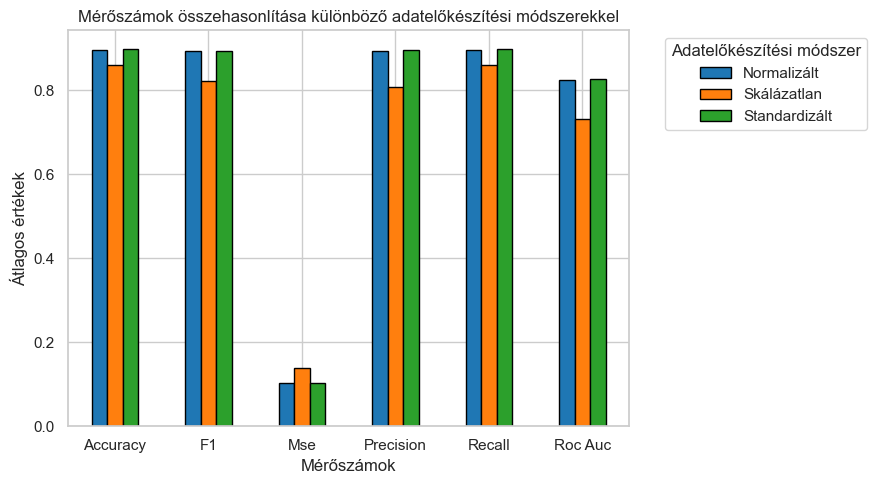

In [408]:
sns.set(style="whitegrid")
colors = sns.color_palette("tab10")
meroszamok.groupby(['Mérőszám', 'Adatelőkészítés'])['Érték'].mean().unstack().plot(kind='bar', color=colors, edgecolor='black')
plt.title('Mérőszámok összehasonlítása különböző adatelőkészítési módszerekkel')
plt.xlabel('Mérőszámok')
plt.xticks(rotation=0)
plt.ylabel('Átlagos értékek')
plt.legend(title='Adatelőkészítési módszer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gcf().set_size_inches(9, 5)
plt.tight_layout()
plt.show()

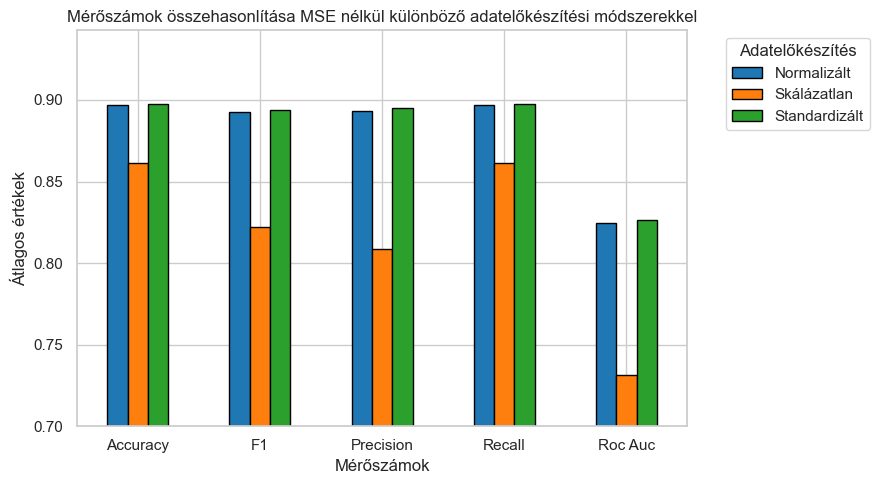

In [409]:
meroszamok[meroszamok['Mérőszám'] != 'Mse'].groupby(['Mérőszám', 'Adatelőkészítés'])['Érték'].mean().unstack().plot(kind='bar', color=colors, edgecolor='black')
plt.title('Mérőszámok összehasonlítása MSE nélkül különböző adatelőkészítési módszerekkel')
plt.xlabel('Mérőszámok')
plt.ylabel('Átlagos értékek')
plt.xticks(rotation=0)
plt.ylim(0.7, plt.ylim()[1])
plt.legend(title='Adatelőkészítés', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gcf().set_size_inches(9, 5)
plt.tight_layout()
plt.show()

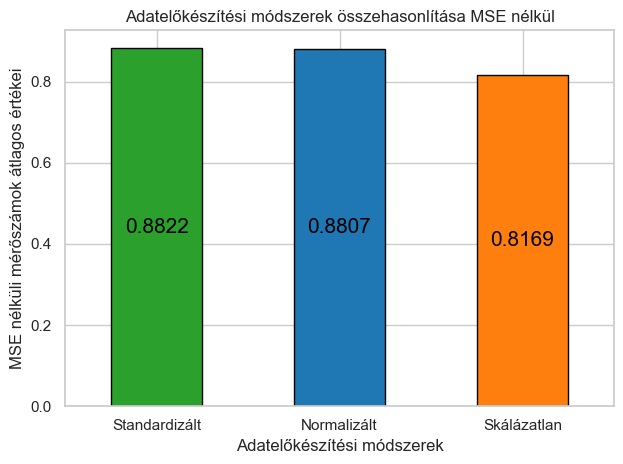

In [410]:
modszerek = meroszamok[meroszamok['Mérőszám'] != 'Mse'].groupby('Adatelőkészítés')['Érték'].mean().sort_values(ascending=False)
szinekjol = ['#2ca02c', '#1f77b4', '#ff7f0e' ]
bar_plot = modszerek.plot(kind='bar', color=szinekjol, edgecolor='black')
for index, value in enumerate(modszerek):
    plt.text(index, value / 2, f'{value:.4f}', ha='center', va='center', color='black', fontsize=15)
plt.title('Adatelőkészítési módszerek összehasonlítása MSE nélkül')
plt.xlabel('Adatelőkészítési módszerek')
plt.ylabel('MSE nélküli mérőszámok átlagos értékei')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

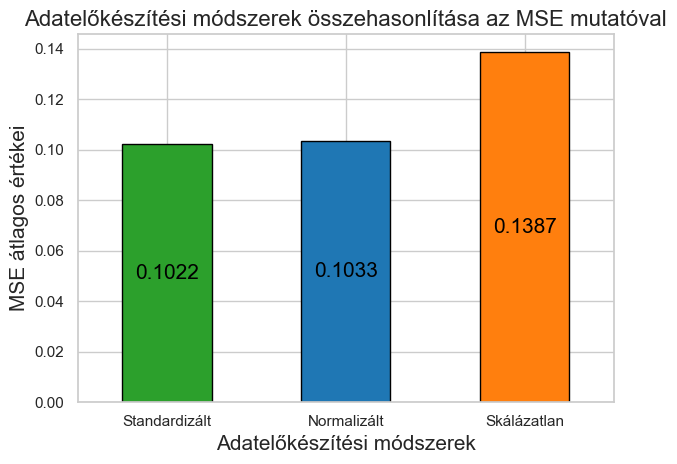

In [411]:
modszerek = meroszamok[meroszamok['Mérőszám'] == 'Mse'].groupby('Adatelőkészítés')['Érték'].mean().sort_values(ascending=True)
bar_plot = modszerek.plot(kind='bar', color=szinekjol, edgecolor='black')
for index, value in enumerate(modszerek):
    plt.text(index, value / 2, f'{value:.4f}', ha='center', va='center', color='black', fontsize=15)
plt.title('Adatelőkészítési módszerek összehasonlítása az MSE mutatóval', fontsize=16)
plt.xlabel('Adatelőkészítési módszerek',fontsize=15)
plt.ylabel('MSE átlagos értékei',fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

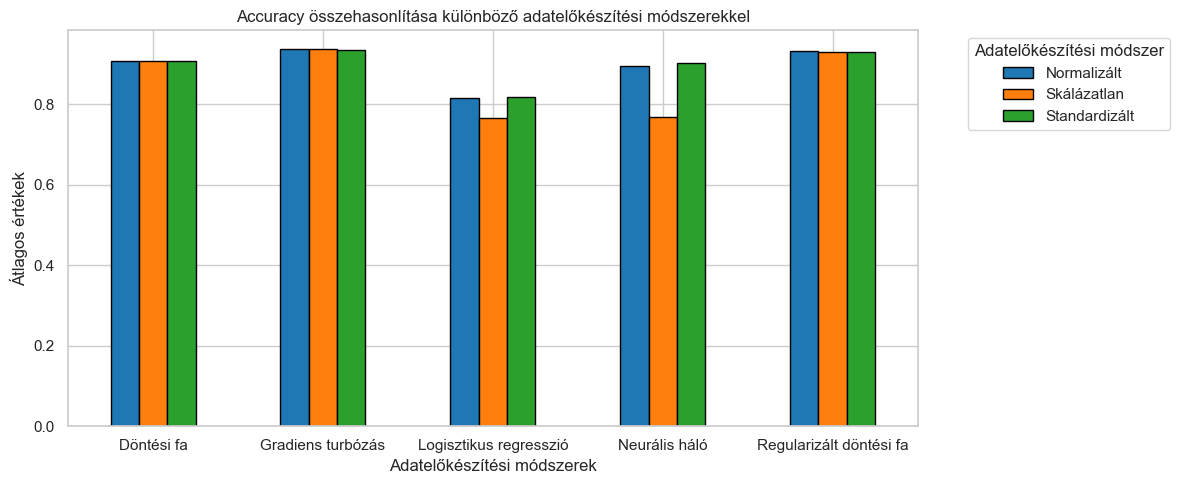

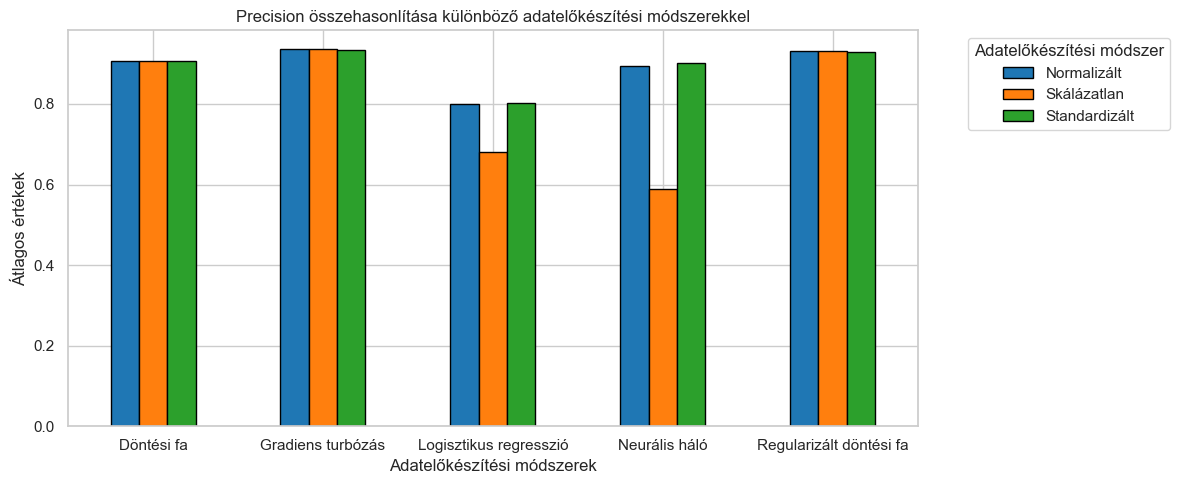

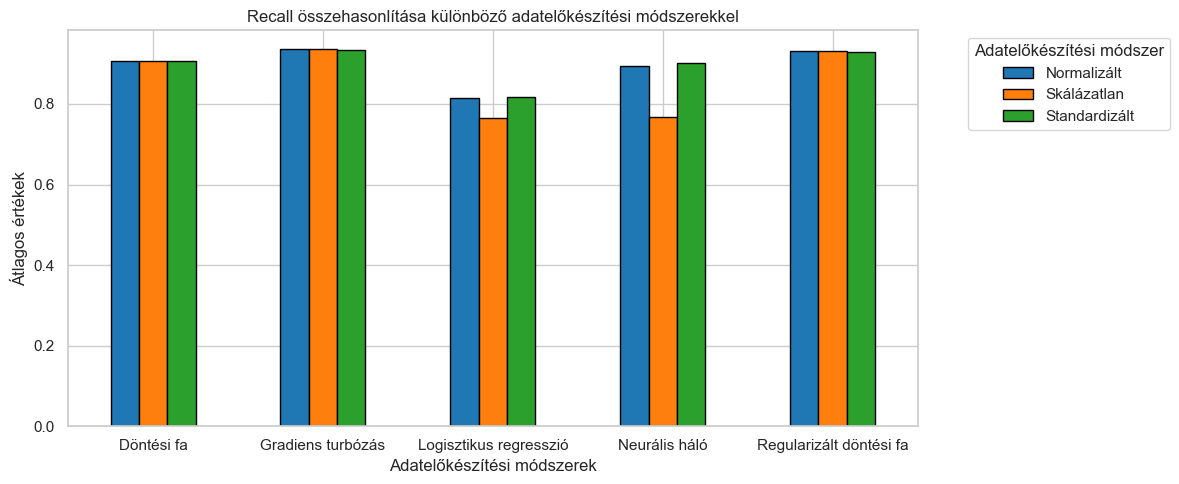

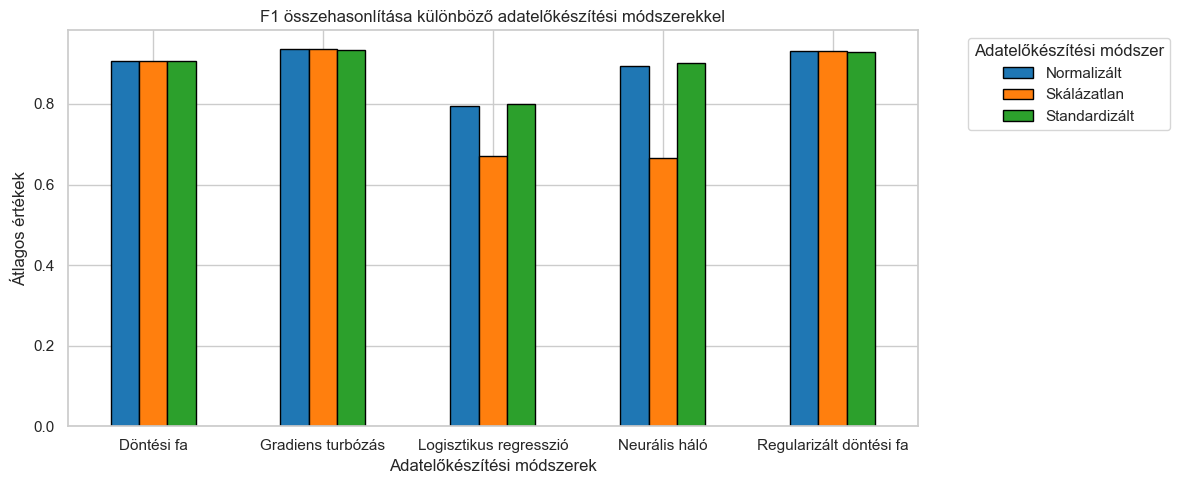

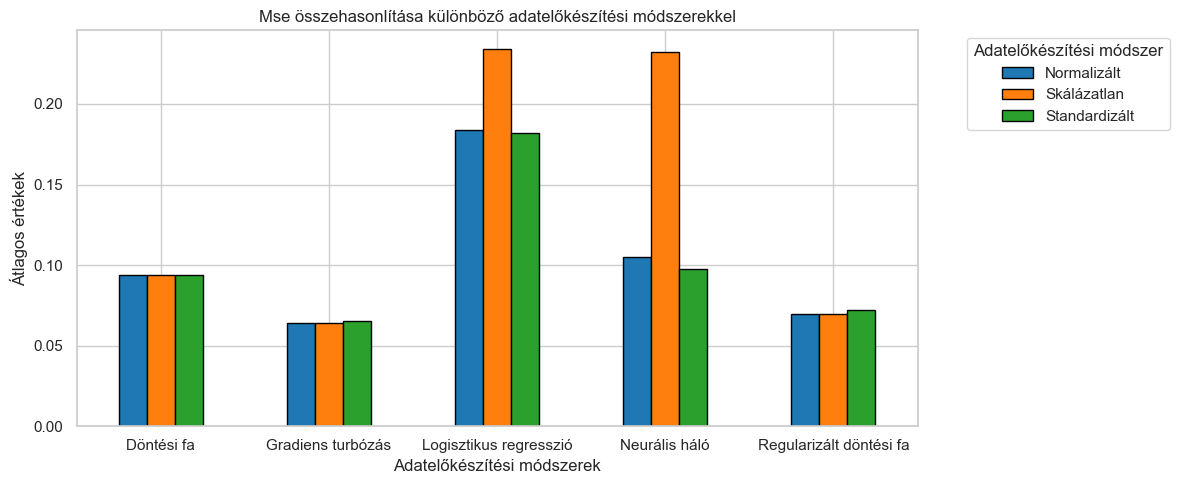

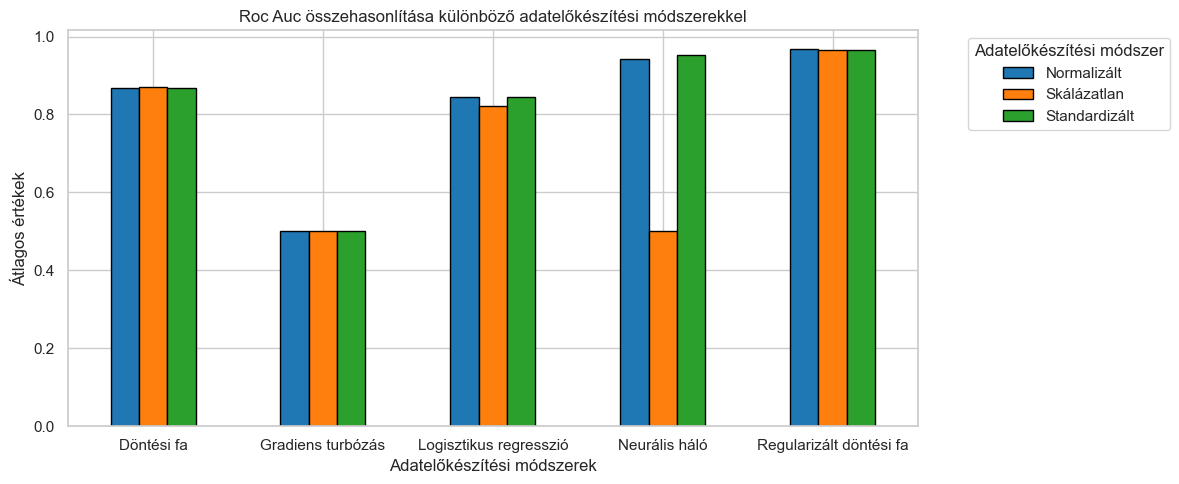

In [412]:
meroszamok_lista = meroszamok['Mérőszám'].unique()

for meroszam in meroszamok_lista:
    adatok = meroszamok[meroszamok['Mérőszám'] == meroszam]
    atlagok = adatok.groupby(['Modell','Adatelőkészítés'])['Érték'].mean().unstack()
    atlagok.plot(kind='bar', color=colors, edgecolor='black')
    plt.title(f'{meroszam} összehasonlítása különböző adatelőkészítési módszerekkel')
    plt.xlabel('Adatelőkészítési módszerek')
    plt.ylabel('Átlagos értékek')
    plt.legend(title='Adatelőkészítési módszer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.gcf().set_size_inches(12, 5)
    plt.tight_layout()
    plt.show()


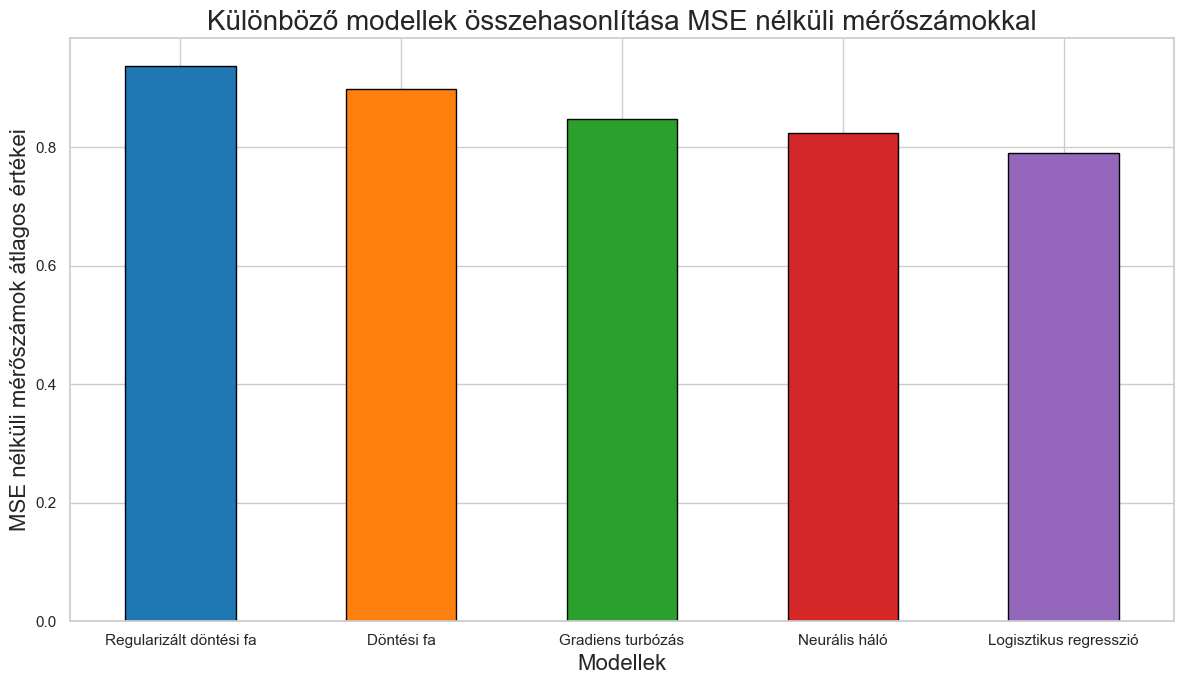

In [413]:
plt.figure(figsize=(10,5))
meroszamok[meroszamok['Mérőszám'] != 'Mse'].groupby(['Modell'])['Érték'].mean().sort_values(ascending=False).plot(kind='bar', color=colors, edgecolor='black')
plt.title('Különböző modellek összehasonlítása MSE nélküli mérőszámokkal', fontsize=20)
plt.xlabel('Modellek',fontsize=16)
plt.xticks(rotation=0)
plt.ylabel('MSE nélküli mérőszámok átlagos értékei', fontsize=16)
plt.gcf().set_size_inches(12, 7)
plt.tight_layout()
plt.show()

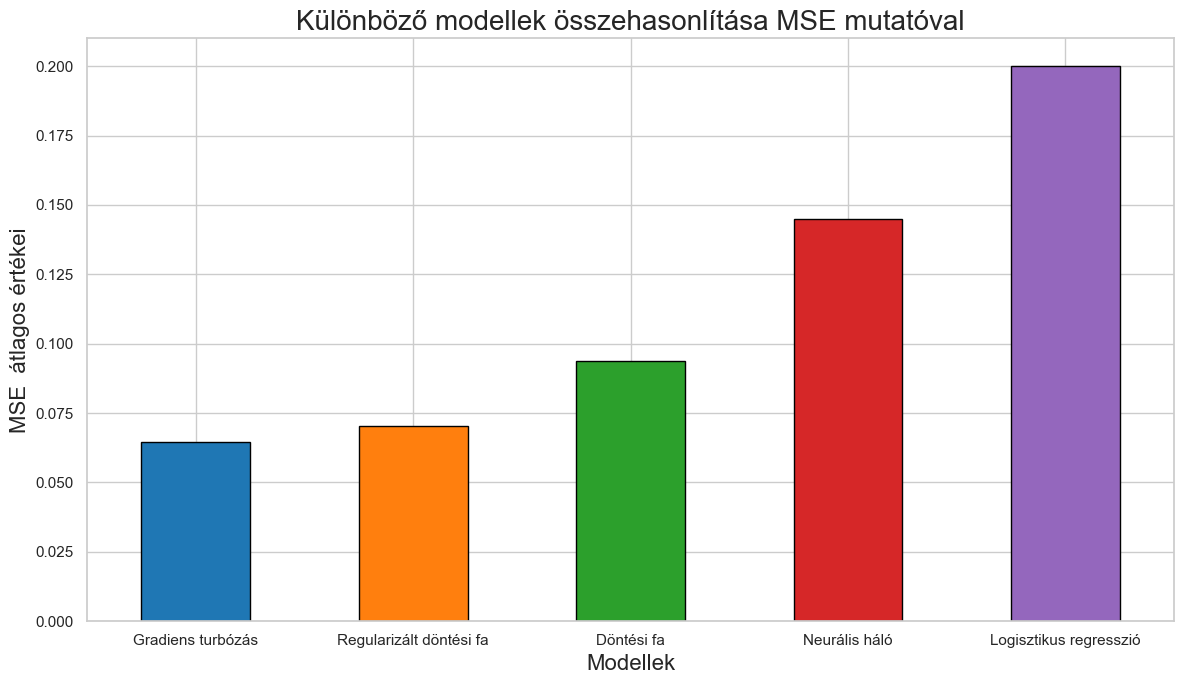

In [414]:
plt.figure(figsize=(10,5))
meroszamok[meroszamok['Mérőszám'] == 'Mse'].groupby(['Modell'])['Érték'].mean().sort_values(ascending=True).plot(kind='bar', color=colors, edgecolor='black')
plt.title('Különböző modellek összehasonlítása MSE mutatóval', fontsize=20)
plt.xlabel('Modellek',fontsize=16)
plt.xticks(rotation=0)
plt.ylabel('MSE  átlagos értékei',fontsize=16)
plt.gcf().set_size_inches(12, 7)
plt.tight_layout()
plt.show()

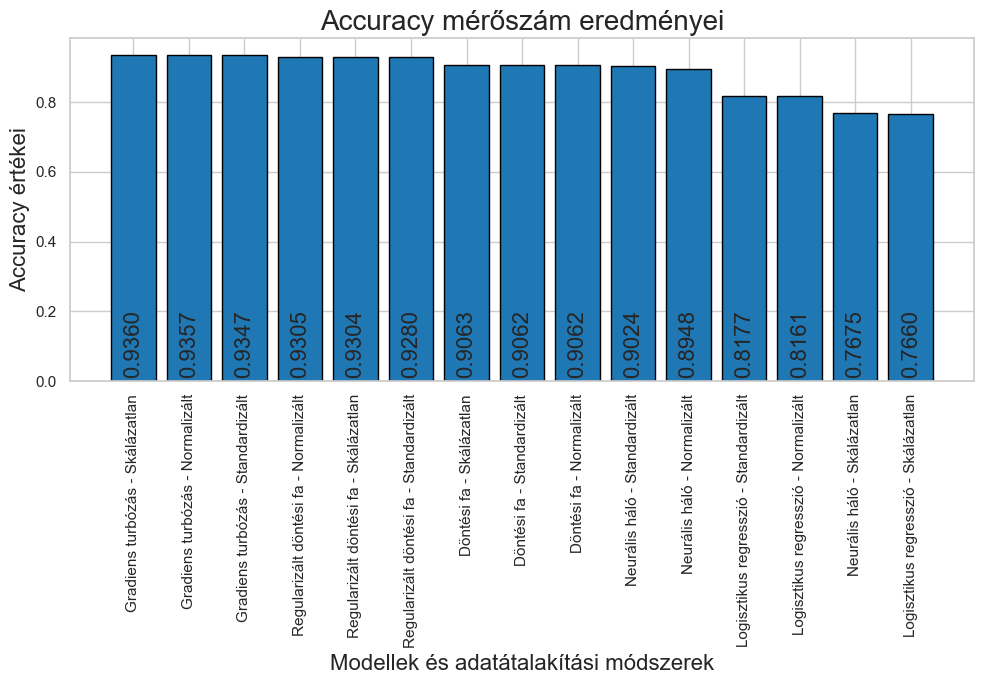

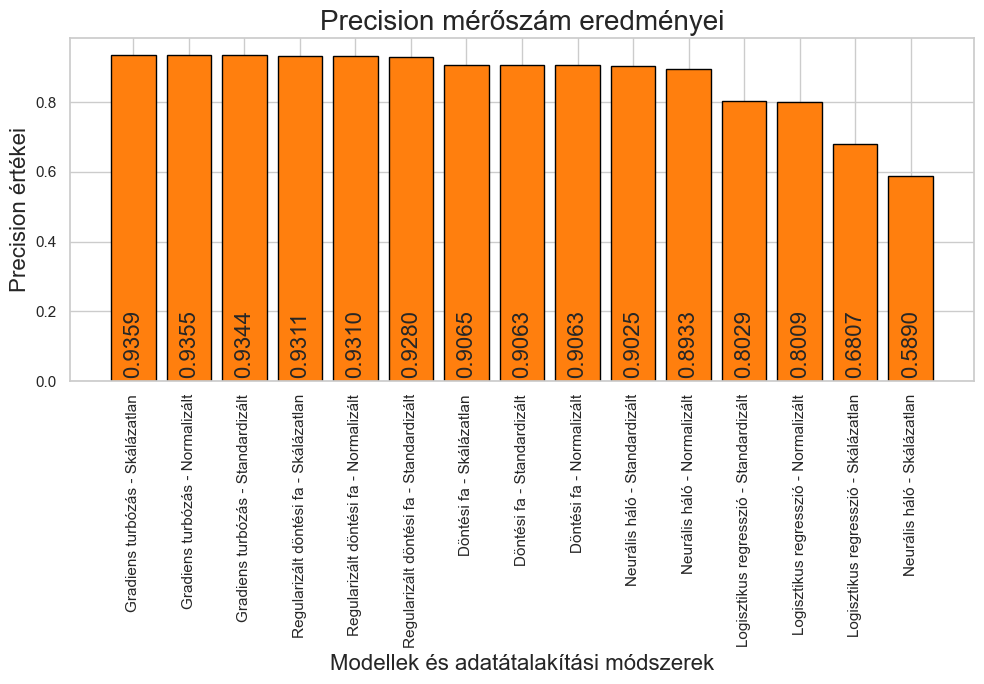

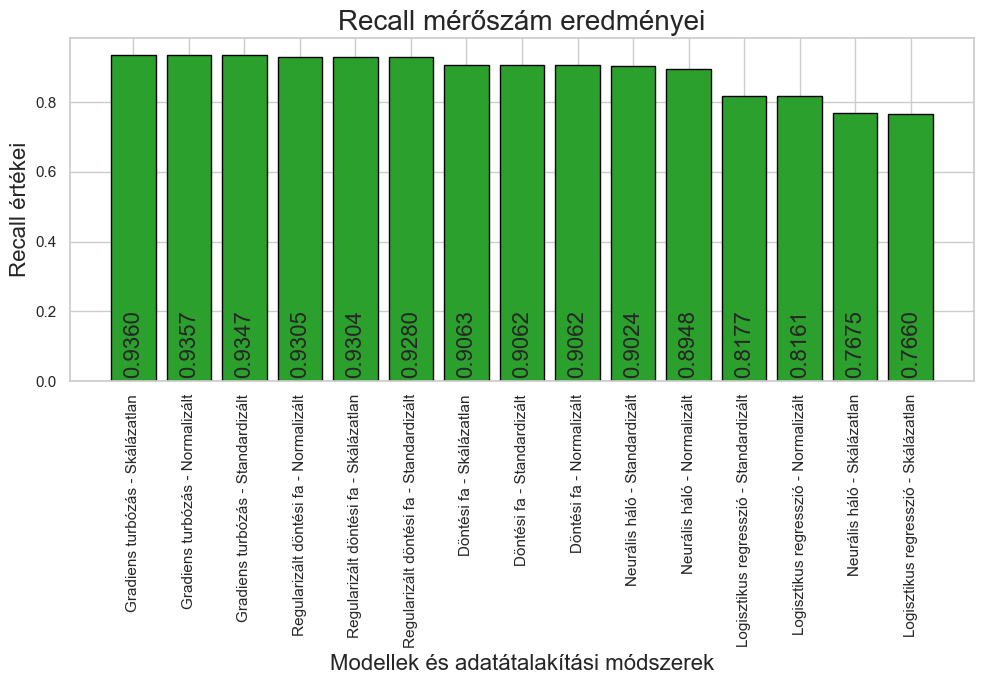

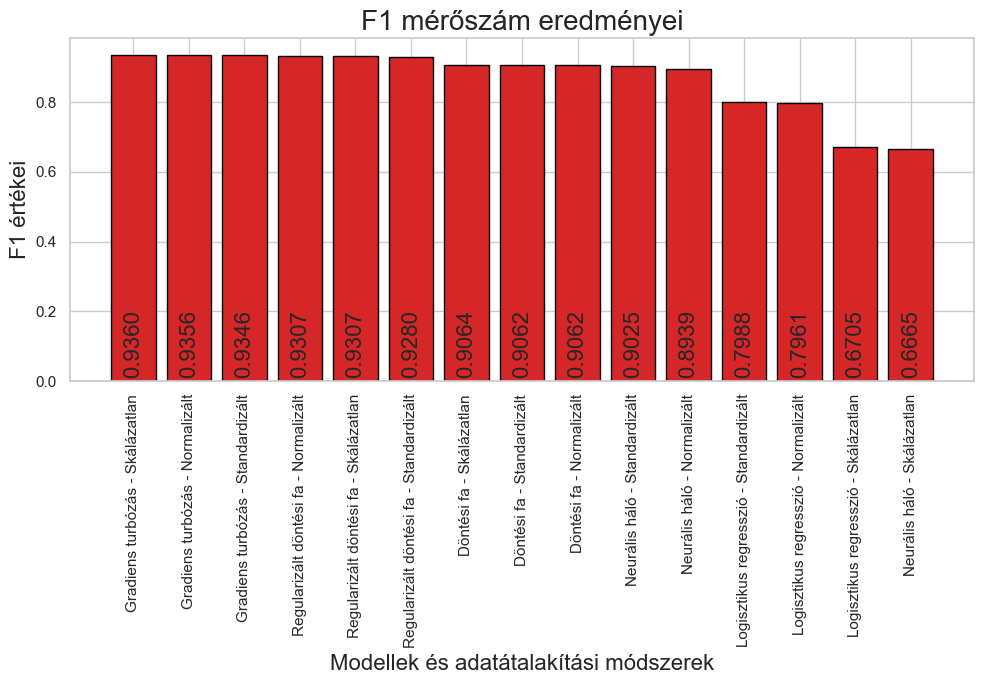

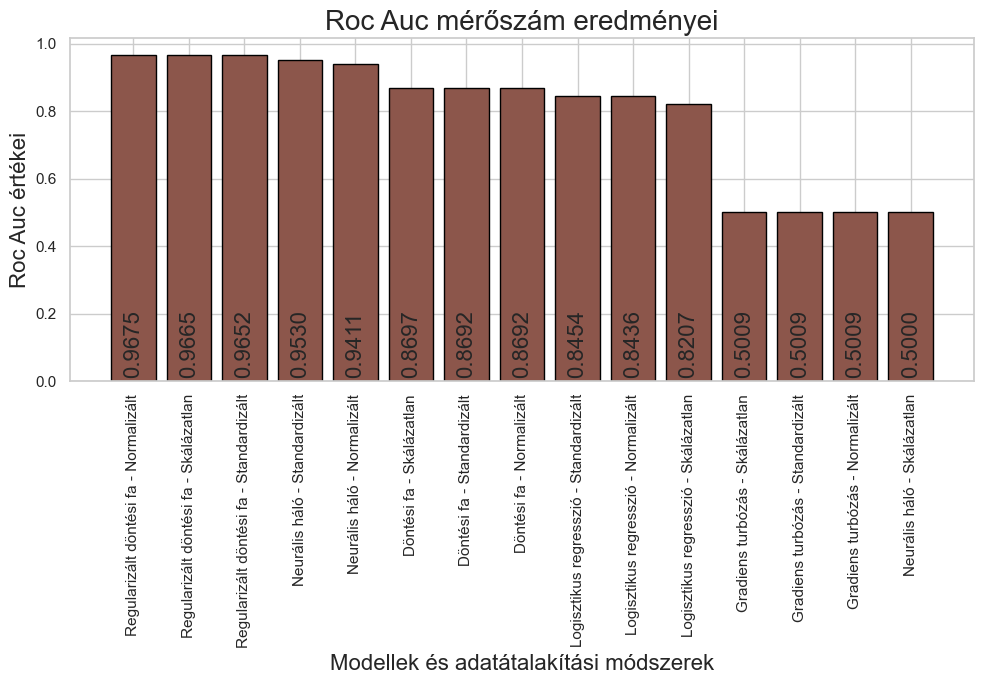

In [415]:
meroszamok_list = meroszamok['Mérőszám'].unique()
for i, meroszam in enumerate(meroszamok_list):
    if meroszam != 'Mse':
        data = meroszamok[meroszamok['Mérőszám'] == meroszam].sort_values('Érték', ascending=False)
        plt.figure(figsize=(10, 7))
        bars = plt.bar(data['Modell_Adat'], data['Érték'], color=colors[i % len(colors)], edgecolor='black')
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, 0.01, f'{yval:.4f}', ha='center', va='bottom', rotation=90, fontsize=16)
        plt.title(f'{meroszam} mérőszám eredményei', fontsize=20)
        plt.xlabel('Modellek és adatátalakítási módszerek', fontsize=16)
        plt.xticks(rotation=90)
        plt.ylabel(f'{meroszam} értékei', fontsize=16)
        plt.tight_layout()
        plt.show()


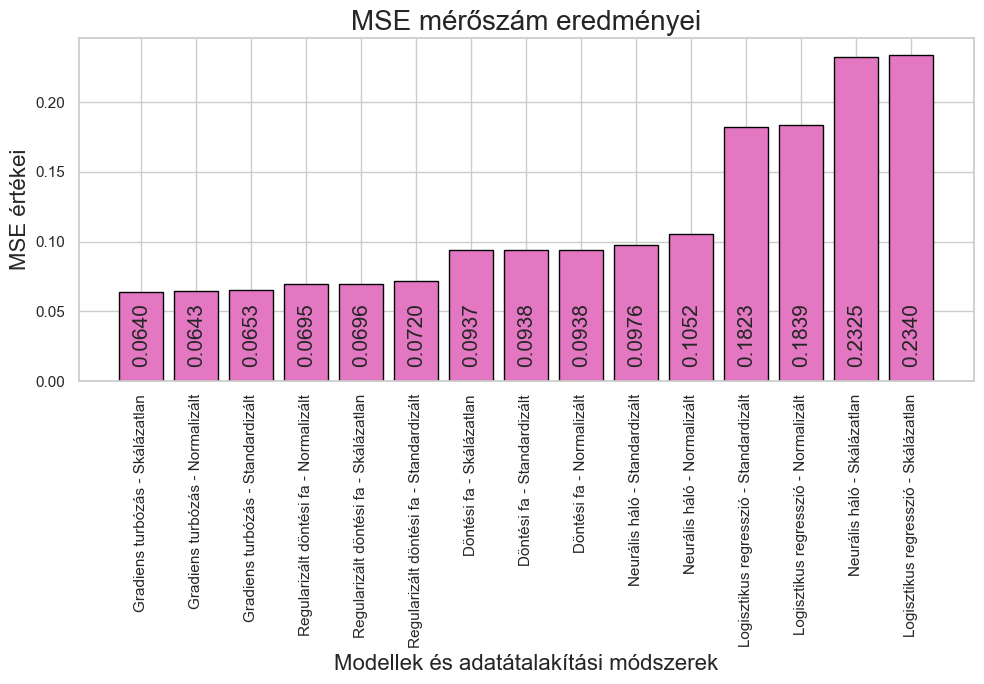

In [416]:
meroszamok['Modell_Adat'] = meroszamok['Modell'] + ' - ' + meroszamok['Adatelőkészítés']
accuracy_data = meroszamok[meroszamok['Mérőszám'] == 'Mse'].sort_values('Érték', ascending=True)
plt.figure(figsize=(10, 7))
bars = plt.bar(accuracy_data['Modell_Adat'], accuracy_data['Érték'], color=colors[6], edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 0.01, f'{yval:.4f}', ha='center', va='bottom', rotation=90, fontsize=15)
plt.title('MSE mérőszám eredményei', fontsize=20)
plt.xlabel('Modellek és adatátalakítási módszerek', fontsize=16)
plt.xticks(rotation=90)
plt.ylabel('MSE értékei', fontsize=16)
plt.tight_layout()
plt.show()

In [417]:
tanulasi_idok_reszletes = {
    "Logisztikus regresszió - Standardizált": training_time_lr_s,
    "Logisztikus regresszió - Skálázatlan": training_time_lr_e,
    "Logisztikus regresszió - Normalizált": training_time_lr_n,
    "Döntési fa - Standardizált": training_time_df_s,
    "Döntési fa - Skálázatlan": training_time_df_e,
    "Döntési fa - Normalizált": training_time_df_n,
    "Regularizált döntési fa - Standardizált": training_time_rdf_s,
    "Regularizált döntési fa - Skálázatlan": training_time_rdf_e,
    "Regularizált döntési fa - Normalizált": training_time_rdf_n,
    "Gradiens turbózás - Standardizált": training_time_gt_s,
    "Gradiens turbózás - Skálázatlan": training_time_gt_e,
    "Gradiens turbózás - Normalizált": training_time_gt_n,
    "Neurális háló - Standardizált": training_time_nn_s,
    "Neurális háló - Skálázatlan": training_time_nn_e,
    "Neurális háló - Normalizált": training_time_nn_n
}

In [418]:
idok = []
for key, value in tanulasi_idok_reszletes.items():
    modell, adatelokeszites = key.rsplit(' - ', 1)
    idok.append({
        'Modell': modell,
        'Adatelőkészítési módszer': adatelokeszites,
        'Tanulási Idő': value,
        'Modell-Adatelőkészítés': key
    })

tanulasi_idok = pd.DataFrame(idok)

<Figure size 1300x1000 with 0 Axes>

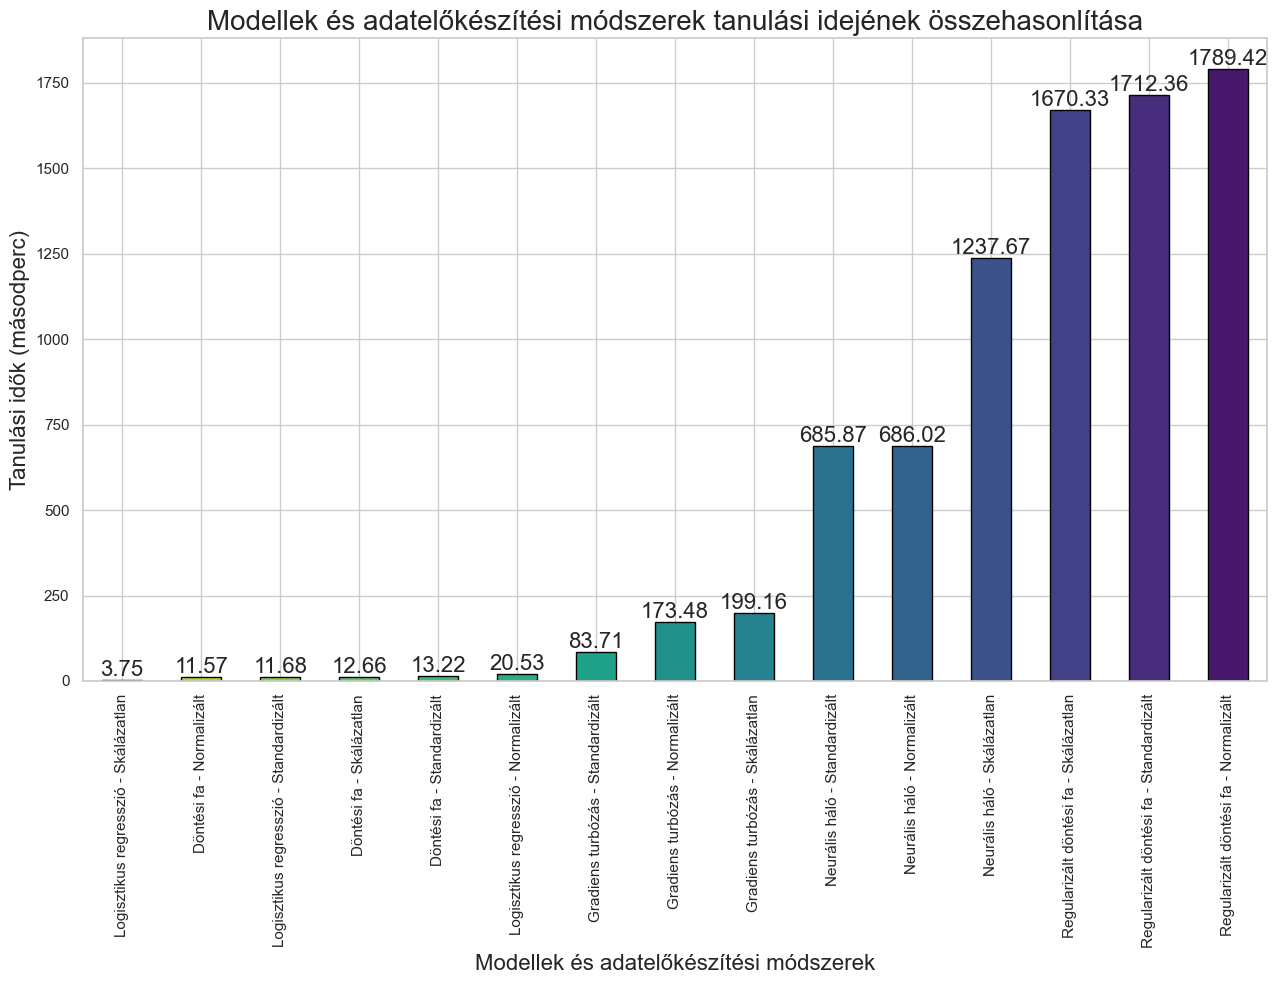

In [419]:
colors = sns.color_palette("viridis", n_colors=len(tanulasi_idok))[::-1]
plt.figure(figsize=(13, 10))
bars = tanulasi_idok.sort_values(by='Tanulási Idő', ascending=True).plot(
    kind='bar',
    x='Modell-Adatelőkészítés',
    y='Tanulási Idő',
    color=colors,
    edgecolor='black',
    legend=False
)
plt.title('Modellek és adatelőkészítési módszerek tanulási idejének összehasonlítása', fontsize=20)
plt.xlabel('Modellek és adatelőkészítési módszerek', fontsize=16)
plt.ylabel('Tanulási idők (másodperc)', fontsize=16)
plt.xticks(rotation=90, ha='center')
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.2f}', ha='center', va='bottom', fontsize=16)
plt.gcf().set_size_inches(13, 10)
plt.tight_layout()
plt.show()

<Figure size 1300x1000 with 0 Axes>

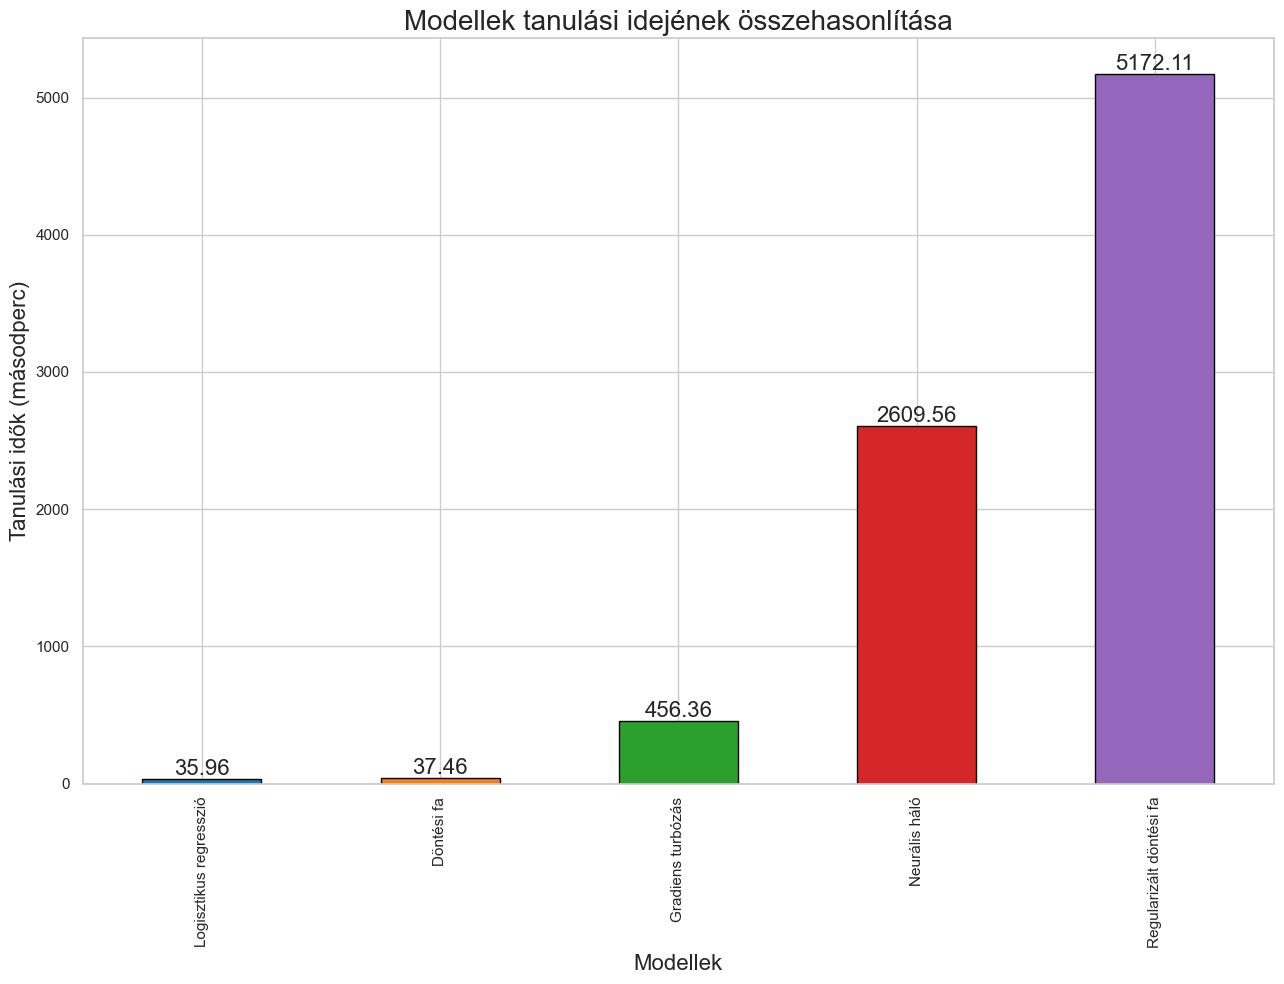

In [420]:
df=tanulasi_idok[['Modell', 'Tanulási Idő']].groupby('Modell').sum().sort_values(by='Tanulási Idő',ascending=True)
df=df.reset_index()
colors = sns.color_palette("tab10")
plt.figure(figsize=(13, 10))
bars = df.sort_values(by='Tanulási Idő', ascending=True).plot(
    kind='bar',
    x='Modell',
    y='Tanulási Idő',
    color=colors,
    edgecolor='black',
    legend=False
)
plt.title('Modellek tanulási idejének összehasonlítása', fontsize=20)
plt.xlabel('Modellek', fontsize=16)
plt.ylabel('Tanulási idők (másodperc)', fontsize=16)
plt.xticks(rotation=90, ha='center')
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.2f}', ha='center', va='bottom', fontsize=16)
plt.gcf().set_size_inches(13, 10)
plt.tight_layout()
plt.show()

<Figure size 1300x1000 with 0 Axes>

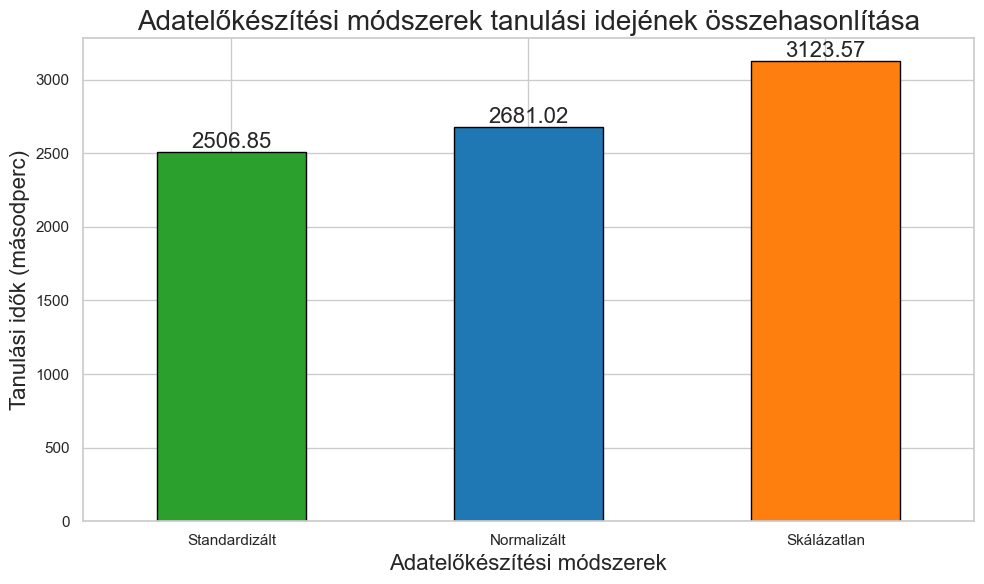

In [421]:
df=tanulasi_idok[['Adatelőkészítési módszer', 'Tanulási Idő']].groupby('Adatelőkészítési módszer').sum().sort_values(by='Tanulási Idő',ascending=True)
df=df.reset_index()
plt.figure(figsize=(13, 10))
bars = df.sort_values(by='Tanulási Idő', ascending=True).plot(
    kind='bar',
    x='Adatelőkészítési módszer',
    y='Tanulási Idő',
    color=szinekjol,
    edgecolor='black',
    legend=False
)
plt.title('Adatelőkészítési módszerek tanulási idejének összehasonlítása', fontsize=20)
plt.xlabel('Adatelőkészítési módszerek', fontsize=16)
plt.ylabel('Tanulási idők (másodperc)', fontsize=16)
plt.xticks(rotation=0, ha='center')
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.2f}', ha='center', va='bottom', fontsize=16)
plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
plt.show()

## Prediktálás

In [110]:
data = {
    'State': ['TX', 'WA', 'NC', 'FL', 'FL'],
    'NAICS': [44, 45, 44, 55, 53],
    'Term': [26, 5, 162, 23, 29],
    'NoEmp': [4, 1, 2, 84, 2],
    'NewExist': [2, 2, 2, 2, 1],
    'CreateJob': [1, 3, 0, 1, 2],
    'RetainedJob': [5, 4, 0, 0, 2],
    'UrbanRural': [2, 1, 1, 1, 1],
    'RevLineCr': [1, 0, 0, 1, 0],
    'LowDoc': [False, False, False, True, False],
    'DisbursementGross': [60859, 28090, 253400, 51440, 170000],
    'SBA_Appv': [10000, 24055, 190050, 17500, 127500],
}
df = pd.DataFrame(data)
df_test=df.copy()

### Skálázatlan adatok

In [111]:
df_test_e = pd.get_dummies(df_test, columns=categoricial_feature_names)
missing_cols = list(set(X_e.columns) - set(df_test_e.columns))
for col in missing_cols:
    df_test_e[col] = 0
df_test_e

,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,SBA_Appv,State_FL,State_NC,...,State_CT,NAICS_22,State_NJ,NAICS_56,NAICS_23,NAICS_71,State_AL,State_GA,State_WY,State_AR
0,26,4,1,5,1,False,60859,10000,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,1,3,4,0,False,28090,24055,0,0,...,0,0,0,0,0,0,0,0,0,0
2,162,2,0,0,0,False,253400,190050,0,1,...,0,0,0,0,0,0,0,0,0,0
3,23,84,1,0,1,True,51440,17500,1,0,...,0,0,0,0,0,0,0,0,0,0
4,29,2,2,2,0,False,170000,127500,1,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
model_file = 'e_gbmodel.txt'
gbm = lgb.Booster(model_file=model_file)

In [113]:
y_pred = gbm.predict(df_test_e, num_iteration=gbm.best_iteration)
predicted_classes = (np.array(y_pred) > 0.5).astype(int)

In [114]:
y_pred

array([0.04635507, 0.07917793, 0.49168125, 0.71224869, 0.08738134])

In [115]:
predicted_classes

array([0, 0, 0, 1, 0])

In [116]:
df['Predicted_e']=y_pred
df['Predicted Class_e']=predicted_classes
df

,State,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,SBA_Appv,Predicted_e,Predicted Class_e
0,TX,44,26,4,2,1,5,2,1,False,60859,10000,0.046355,0
1,WA,45,5,1,2,3,4,1,0,False,28090,24055,0.079178,0
2,NC,44,162,2,2,0,0,1,0,False,253400,190050,0.491681,0
3,FL,55,23,84,2,1,0,1,1,True,51440,17500,0.712249,1
4,FL,53,29,2,1,2,2,1,0,False,170000,127500,0.087381,0


### Standardizált adatok

In [119]:
df_test_s=df_test.copy()
df_test_s[numeric_feature_names] = ss.transform(df_test_s[numeric_feature_names])
df_test_s = pd.get_dummies(df_test_s, columns=categoricial_feature_names)
missing_cols = list(set(X_s.columns) - set(df_test_s.columns))
for col in missing_cols:
    df_test_s[col] = 0
df_test_s

,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,SBA_Appv,State_FL,State_NC,...,State_CT,NAICS_22,State_NJ,NAICS_56,NAICS_23,NAICS_71,State_AL,State_GA,State_WY,State_AR
0,-0.997050,-0.105850,-0.105210,-0.043975,1,False,-0.425590,-0.500711,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1.295675,-0.172504,0.045113,-0.088447,0,False,-0.530887,-0.444695,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.936903,-0.150286,-0.180372,-0.266334,0,False,0.193103,0.216879,0,1,...,0,0,0,0,0,0,0,0,0,0
3,-1.039711,1.671586,-0.105210,-0.266334,1,True,-0.455856,-0.470820,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.954390,-0.150286,-0.030048,-0.177390,0,False,-0.074887,-0.032414,1,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
model_file = 's_gbmodel.txt'
gbm = lgb.Booster(model_file=model_file)
y_pred = gbm.predict(df_test_s, num_iteration=gbm.best_iteration)
predicted_classes = (np.array(y_pred) > 0.5).astype(int)

In [121]:
y_pred

array([0.05513695, 0.10303023, 0.54672881, 0.344206  , 0.10769492])

In [122]:
predicted_classes

array([0, 0, 1, 0, 0])

In [123]:
df['Predicted_s']=y_pred
df['Predicted Class_s']=predicted_classes

### Normalizált adatok

In [124]:
df_test_n=df_test.copy()
df_test_n[numeric_feature_names] = normalizer.transform(df_test_n[numeric_feature_names])
df_test_n = pd.get_dummies(df_test_n, columns=categoricial_feature_names)
missing_cols = list(set(X_n.columns) - set(df_test_n.columns))
for col in missing_cols:
    df_test_n[col] = 0
df_test_n

,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,SBA_Appv,State_FL,State_NC,...,State_CT,NAICS_22,State_NJ,NAICS_56,NAICS_23,NAICS_71,State_AL,State_GA,State_WY,State_AR
0,0.045694,0.000500,0.000197,0.000526,1,False,0.004969,0.002111,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.008787,0.000125,0.000590,0.000421,0,False,0.002105,0.005235,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.284710,0.000250,0.000000,0.000000,0,False,0.021796,0.042127,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.040422,0.010500,0.000197,0.000000,1,True,0.004146,0.003778,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.050967,0.000250,0.000393,0.000211,0,False,0.014508,0.028225,1,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
model_file = 'n_gbmodel.txt'
gbm = lgb.Booster(model_file=model_file)
y_pred = gbm.predict(df_test_n, num_iteration=gbm.best_iteration)
predicted_classes = (np.array(y_pred) > 0.5).astype(int)

In [126]:
y_pred

array([0.05000113, 0.07782457, 0.43288475, 0.97414762, 0.06612505])

In [127]:
predicted_classes

array([0, 0, 0, 1, 0])

In [128]:
df['Predicted_n']=y_pred
df['Predicted Class_n']=predicted_classes

In [129]:
df

,State,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,SBA_Appv,Predicted_e,Predicted Class_e,Predicted_s,Predicted Class_s,Predicted_n,Predicted Class_n
0,TX,44,26,4,2,1,5,2,1,False,60859,10000,0.046355,0,0.055137,0,0.050001,0
1,WA,45,5,1,2,3,4,1,0,False,28090,24055,0.079178,0,0.103030,0,0.077825,0
2,NC,44,162,2,2,0,0,1,0,False,253400,190050,0.491681,0,0.546729,1,0.432885,0
3,FL,55,23,84,2,1,0,1,1,True,51440,17500,0.712249,1,0.344206,0,0.974148,1
4,FL,53,29,2,1,2,2,1,0,False,170000,127500,0.087381,0,0.107695,0,0.066125,0


In [130]:
df[['Predicted_e','Predicted Class_e','Predicted_s','Predicted Class_s','Predicted_n','Predicted Class_n']]

,Predicted_e,Predicted Class_e,Predicted_s,Predicted Class_s,Predicted_n,Predicted Class_n
0,0.046355,0,0.055137,0,0.050001,0
1,0.079178,0,0.103030,0,0.077825,0
2,0.491681,0,0.546729,1,0.432885,0
3,0.712249,1,0.344206,0,0.974148,1
4,0.087381,0,0.107695,0,0.066125,0
